In [27]:
# Imports and utils

import os
import argparse
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

cudnn.benchmark = True

import sys
sys.path.append('../../')
sys.path.append('../../..')
sys.path.append('')

sys.path.append('/home/yau/sequencing_the_neuron/reconstruction/uti')

from mdistiller.models import cifar_model_dict, imagenet_model_dict
from mdistiller.distillers import distiller_dict
from mdistiller.dataset import get_dataset
from mdistiller.engine.utils import load_checkpoint, log_msg
from mdistiller.engine.cfg import CFG as cfg
from mdistiller.engine.cfg import show_cfg

# get cifar100 class list
from mdistiller.dataset.cifar100 import get_data_folder
import torchvision.datasets as datasets

class_names = datasets.CIFAR100(root=get_data_folder(), train=False, download=True).classes

In [2]:
# Loading LDA checkpoint

def load_LDA(cfg_path, checkpoint):
    cfg.merge_from_file(cfg_path)
    cfg.freeze()
    log_msg(show_cfg(cfg))
    num_classes = 100
    
    model_student = cifar_model_dict[cfg.DISTILLER.STUDENT][0](
        num_classes=num_classes
    )
    
    net, pretrain_model_path = cifar_model_dict[cfg.DISTILLER.TEACHER]
    assert (
        pretrain_model_path is not None
    ), "no pretrain model for teacher {}".format(cfg.DISTILLER.TEACHER)
    model_teacher = net(num_classes=num_classes)

    distiller = distiller_dict[cfg.DISTILLER.TYPE](model_student, model_teacher, cfg)
    distiller = nn.DataParallel(distiller)
    distiller.load_state_dict(load_checkpoint(checkpoint)["model"])
    return distiller, cfg

In [31]:
student_ckpt = "/workspace/disagreement_augmentation_v2/output/cifar100_baselines/kd,res32x4,res8x4/student_best"
cfg_path = "/workspace/disagreement_augmentation_v2/configs/cifar100/lda/resnet32x4_resnet8x4.yaml"

cfg.merge_from_file(cfg_path)
cfg.freeze()
log_msg(show_cfg(cfg))
num_classes = 100

model_student = cifar_model_dict["resnet8x4"][0](
        num_classes=num_classes
    )

model_student.load_state_dict(load_checkpoint(student_ckpt)["model"])

net, pretrain_model_path = cifar_model_dict[cfg.DISTILLER.TEACHER]
assert (
    pretrain_model_path is not None
), "no pretrain model for teacher {}".format(cfg.DISTILLER.TEACHER)
model_teacher = net(num_classes=num_classes)
model_teacher.load_state_dict(load_checkpoint(pretrain_model_path)["model"])



distiller = distiller_dict[cfg.DISTILLER.TYPE](model_student, model_teacher, cfg)
distiller = nn.DataParallel(distiller)

train_loader, val_loader, num_data, num_classes = get_dataset(cfg)



[INFO] CONFIG:
DATASET:
  NUM_WORKERS: 2
  SUBSET: null
  TEST:
    BATCH_SIZE: 64
  TYPE: cifar100
DISTILLER:
  STUDENT: resnet8x4
  TEACHER: resnet32x4
  TYPE: LDA
EXPERIMENT:
  DA: true
  NAME: resnet32x4_resnet8x4_da
  PROJECT: latent_da_final
  TAG: kd,resnet32x4,resnet8x4
LOG:
  PREFIX: ./output
  SAVE_CHECKPOINT_FREQ: 40
  TENSORBOARD_FREQ: 500
  WANDB: true
SOLVER:
  BATCH_SIZE: 64
  DOT:
    DELTA: 0.075
  EPOCHS: 240
  LR: 0.05
  LR_DECAY_RATE: 0.1
  LR_DECAY_STAGES:
  - 150
  - 180
  - 210
  MOMENTUM: 0.9
  TRAINER: base
  TYPE: SGD
  WEIGHT_DECAY: 0.0005



In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [20]:
import copy
def DA(images, distiller, epochs, lr=0.01778):
        fake_student = copy.deepcopy(distiller.student)
        images = images.detach().clone().requires_grad_(True)
        optimizer = torch.optim.Adam([images], lr=lr)
        for _ in range(epochs):
            logits_student, _ = fake_student(images)
            logits_student = torch.nn.functional.normalize(logits_student, p=1.0, dim=-1)
            logits_teacher, _ = distiller.teacher(images)
            logits_teacher = torch.nn.functional.normalize(logits_teacher, p=1.0, dim=-1)
            loss = -1 * F.mse_loss(logits_student, logits_teacher)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        return images.detach().clone()

In [22]:
def LDA(images, distiller, epochs, lr=0.01778):
        """Latent Disagreement Augmentation"""
        device = images.device
        image = images.clone()
            
        try:
            # Process the image through the encoder to get latent
            with torch.no_grad():
                denormalized_image = distiller.denormalize(image)
                # Resize to fit encoder input size
                resized_image = F.interpolate(denormalized_image, size=(256, 256), mode='bilinear', align_corners=False)
                latent = distiller.ae.encoder(resized_image)
            
            # Create a fresh tensor with gradients
            latent = latent.detach().clone().to(device).requires_grad_(True)
            
            # Create optimizer for the latent
            optimizer = torch.optim.Adam([latent], lr=float(lr))
            
            # Store model modes and set to eval during optimization
            student_training = distiller.student.training
            teacher_training = distiller.teacher.training
            distiller.student.eval()
            distiller.teacher.eval()
            
            # Optimization loop for latent
            for i in range(int(epochs)):
                optimizer.zero_grad()
                
                # Forward through decoder (with gradient)
                decoded_image = distiller.ae.decoder(latent)
                decoded_image = torch.clamp(decoded_image, 0, 1)
                normalized_image = distiller.norm(decoded_image)
                resized_image = F.interpolate(normalized_image, size=(32, 32), mode='bilinear', align_corners=False)
                
                # Get model predictions
                
                logits_student, _ = distiller.student(resized_image)
                logits_teacher, _ = distiller.teacher(resized_image)
                
                # Calculate loss on detached logits (focusing gradient on latent only)
                normalized_student = F.normalize(logits_student, p=1, dim=1)
                normalized_teacher = F.normalize(logits_teacher, p=1, dim=1)
                
                # Maximize disagreement
                disagreement_loss = -1.0 * F.mse_loss(normalized_student, normalized_teacher)
                
                # Create a dummy variable with gradient that depends on the latent
                # This ensures we have a proper gradient path
                dummy_loss = torch.sum(resized_image * 0.0)
                
                # Total loss combines the disagreement with the dummy connection
                total_loss = disagreement_loss # + dummy_loss
                
                # Backward pass and optimization step
                total_loss.backward()
                optimizer.step()
            
            # Reset models to their original training modes
            if student_training:
                distiller.student.train()
            if teacher_training:
                distiller.teacher.train()
            
            # Generate the final augmented image
            with torch.no_grad():
                decoded_image = distiller.ae.decoder(latent)
                decoded_image = torch.clamp(decoded_image, 0, 1)
                normalized_image = distiller.norm(decoded_image)
                augmented_image = F.interpolate(normalized_image, size=(32, 32), mode='bilinear', align_corners=False)
                
                result = augmented_image
                    
            return result.detach()
            
        except Exception as e:
            print(f"Detailed DA error: {type(e).__name__}: {e}")
            # Return original images on error
            return images

In [ ]:
# from mdistiller.engine.utils import validate

# validate(val_loader, distiller)

Top-1:73.560| Top-5:92.920


(tensor(73.5600, device='cuda:0'),
 tensor(92.9200, device='cuda:0'),
 np.float32(1.1098789))

Detailed DA error: OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 23.55 GiB of which 113.75 MiB is free. Process 1211219 has 23.43 GiB memory in use. Of the allocated memory 21.74 GiB is allocated by PyTorch, and 1.22 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Detailed DA error: OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 23.55 GiB of which 113.75 MiB is free. Process 1211219 has 23.43 GiB memory in use. Of the allocated memory 21.74 GiB is allocated by PyTorch, and 1.22 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation. 

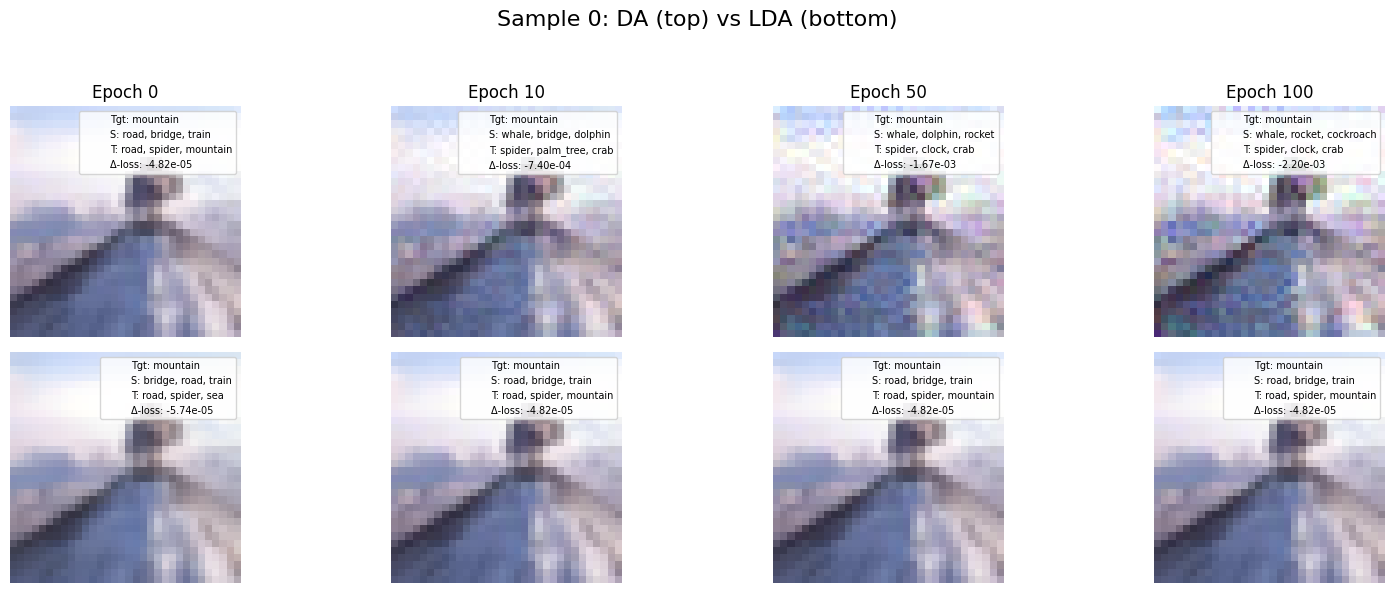

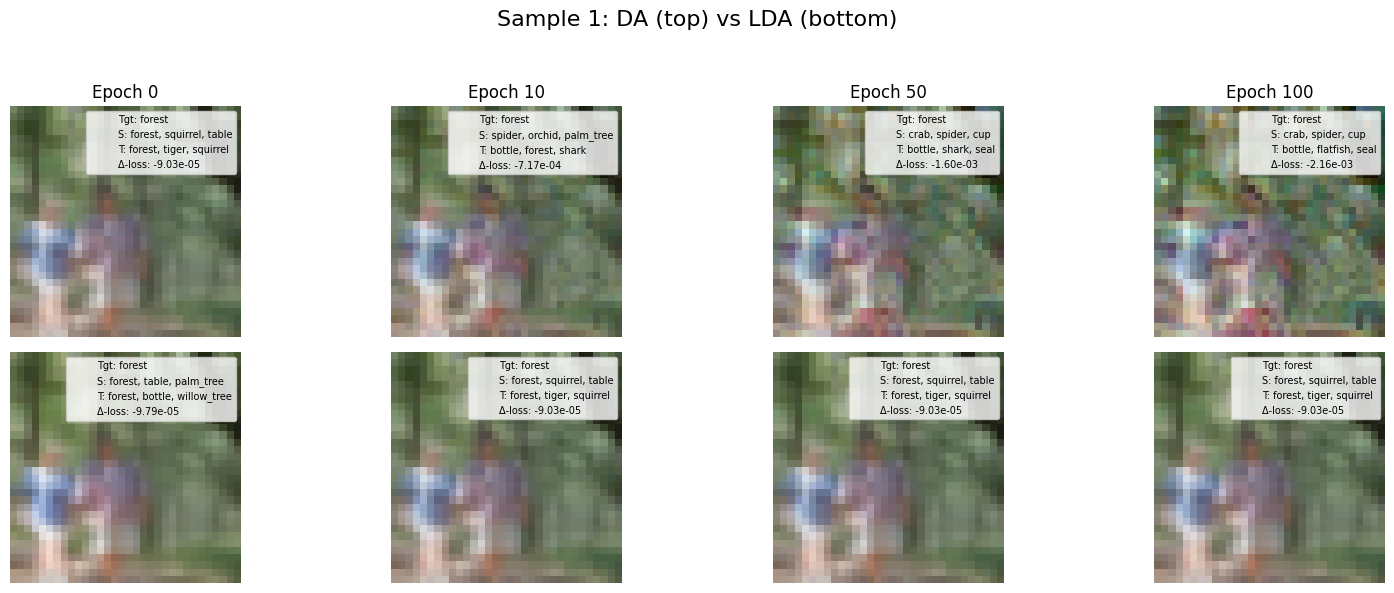

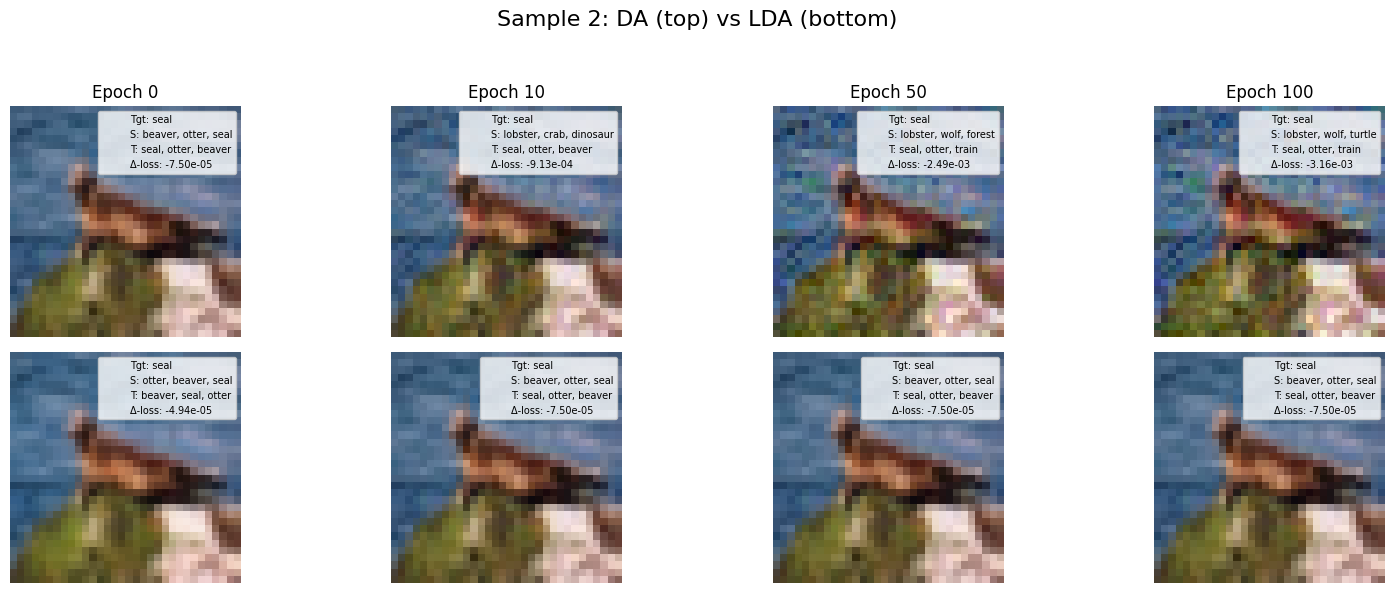

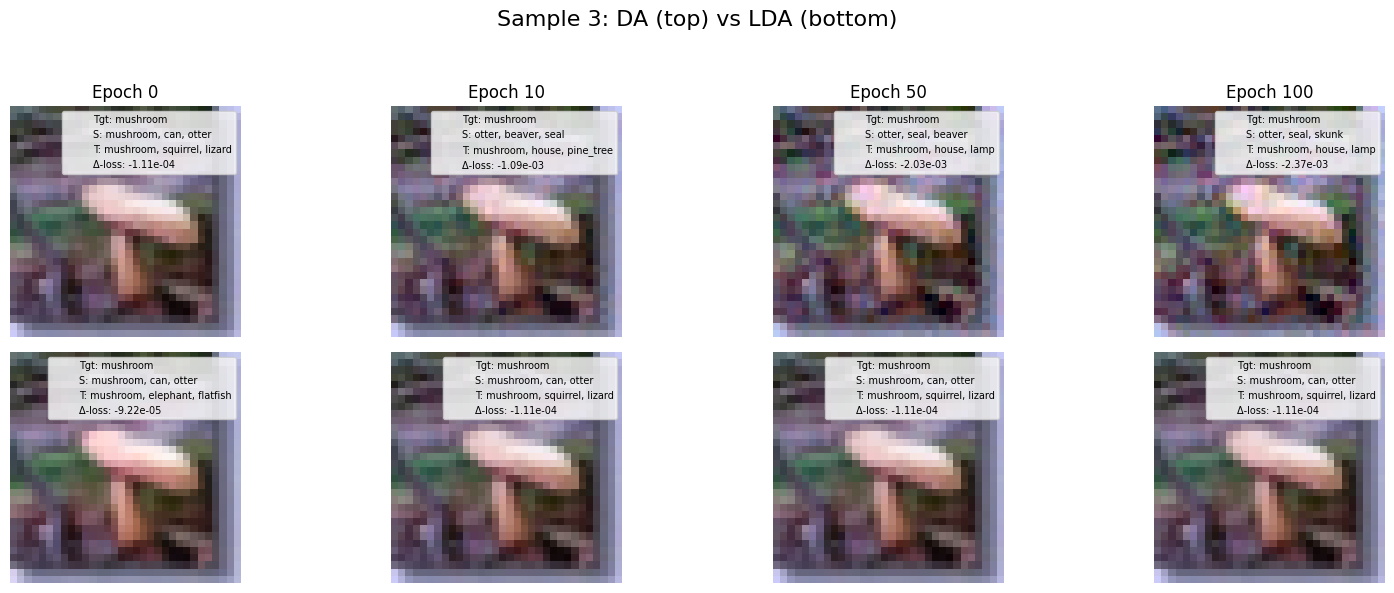

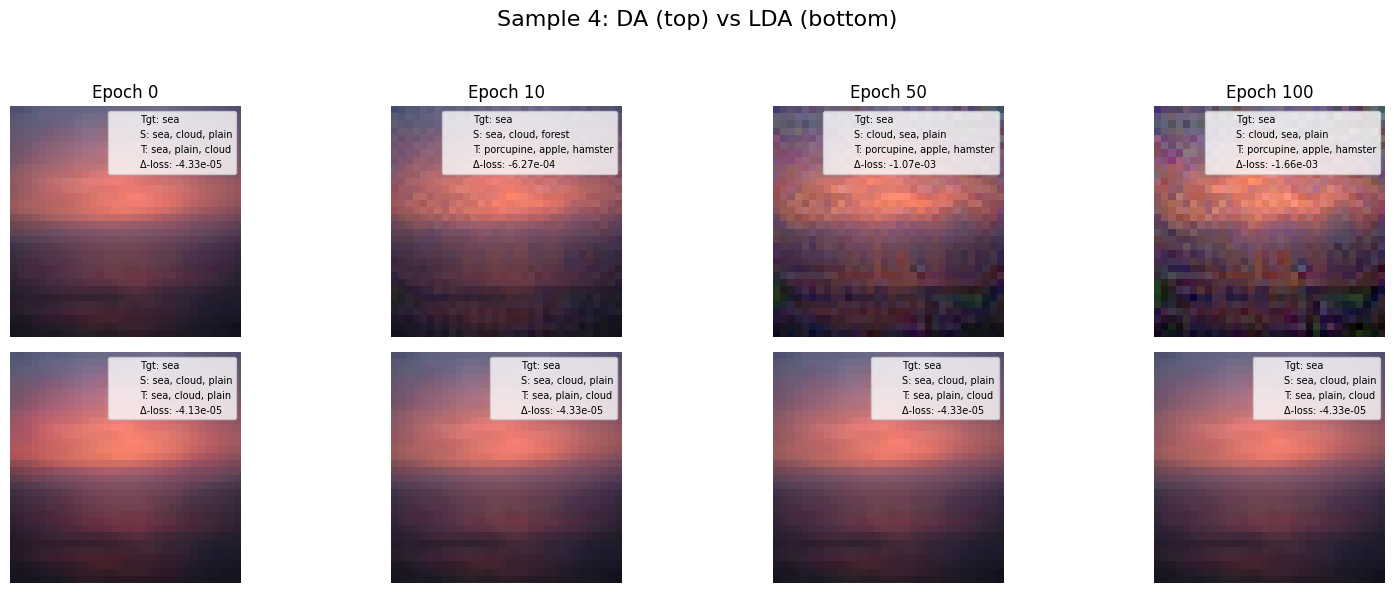

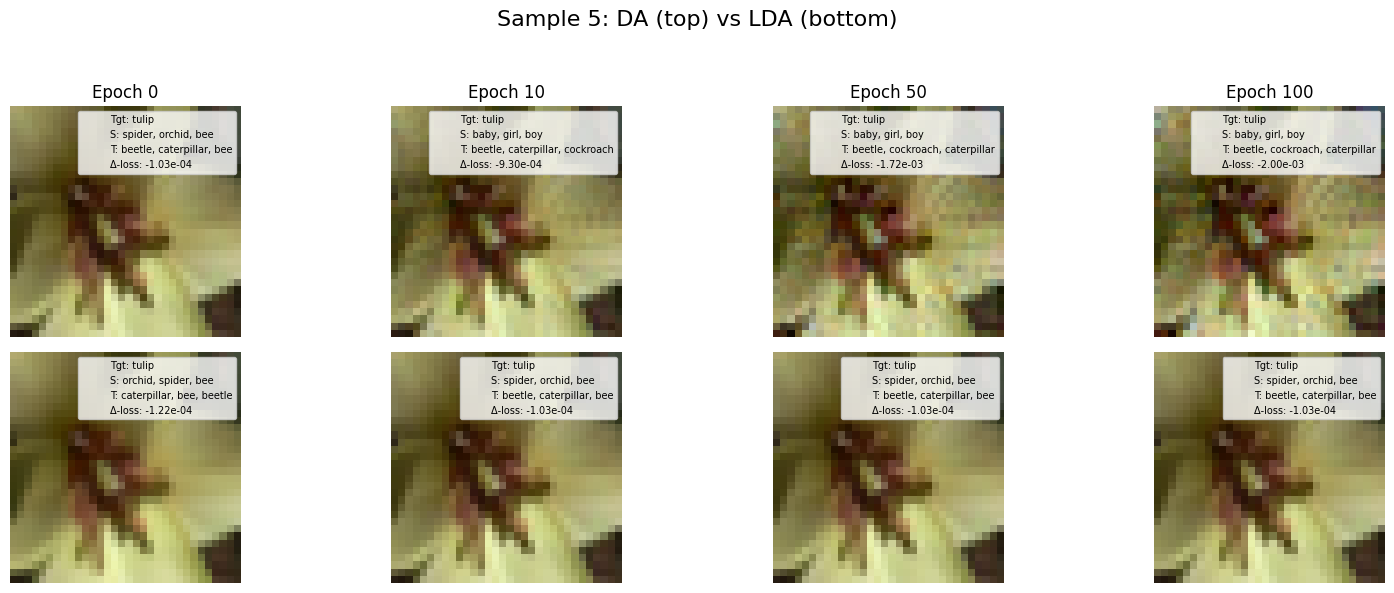

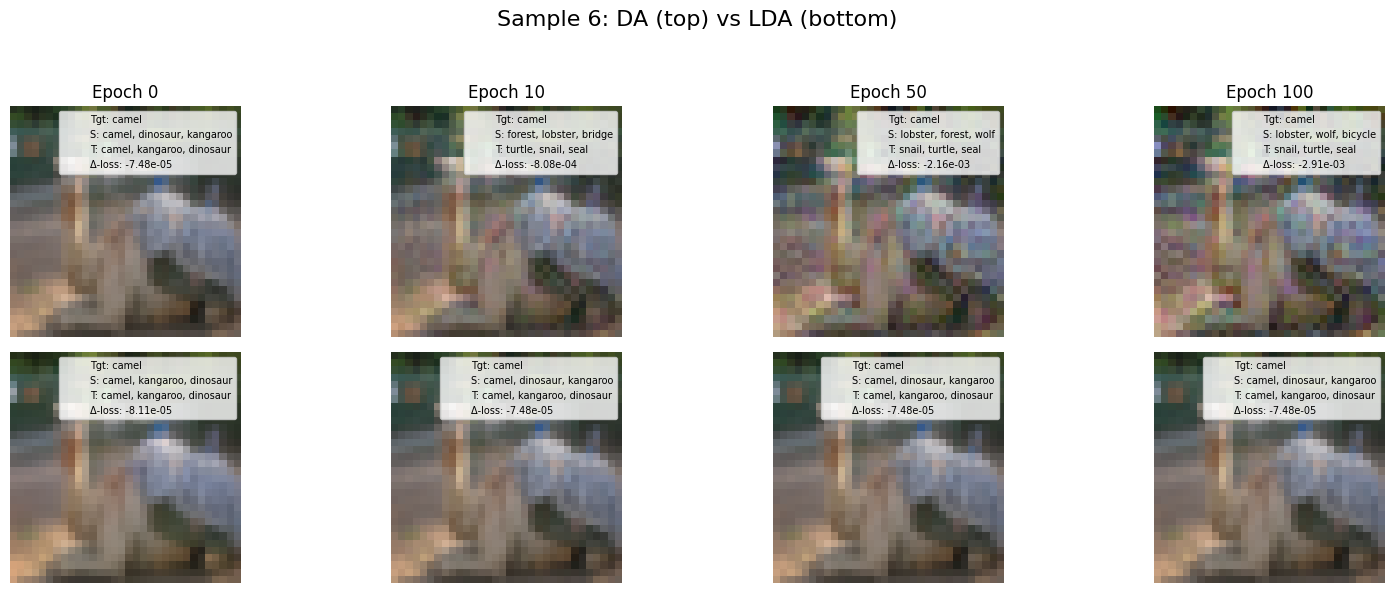

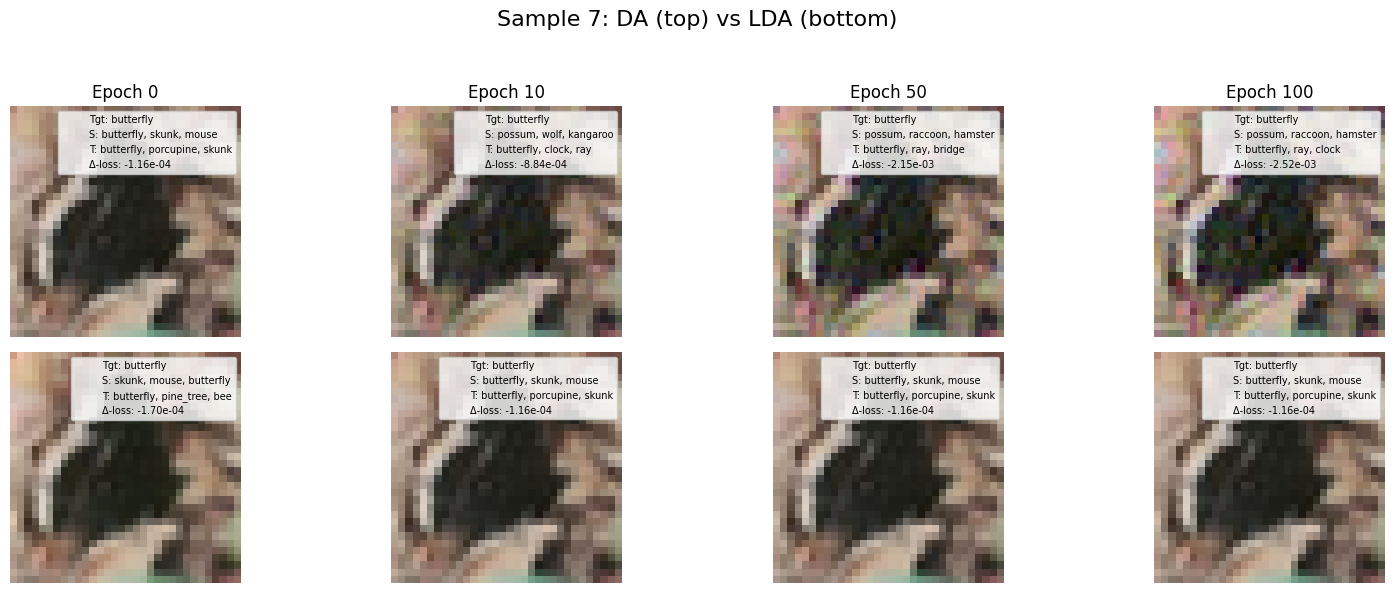

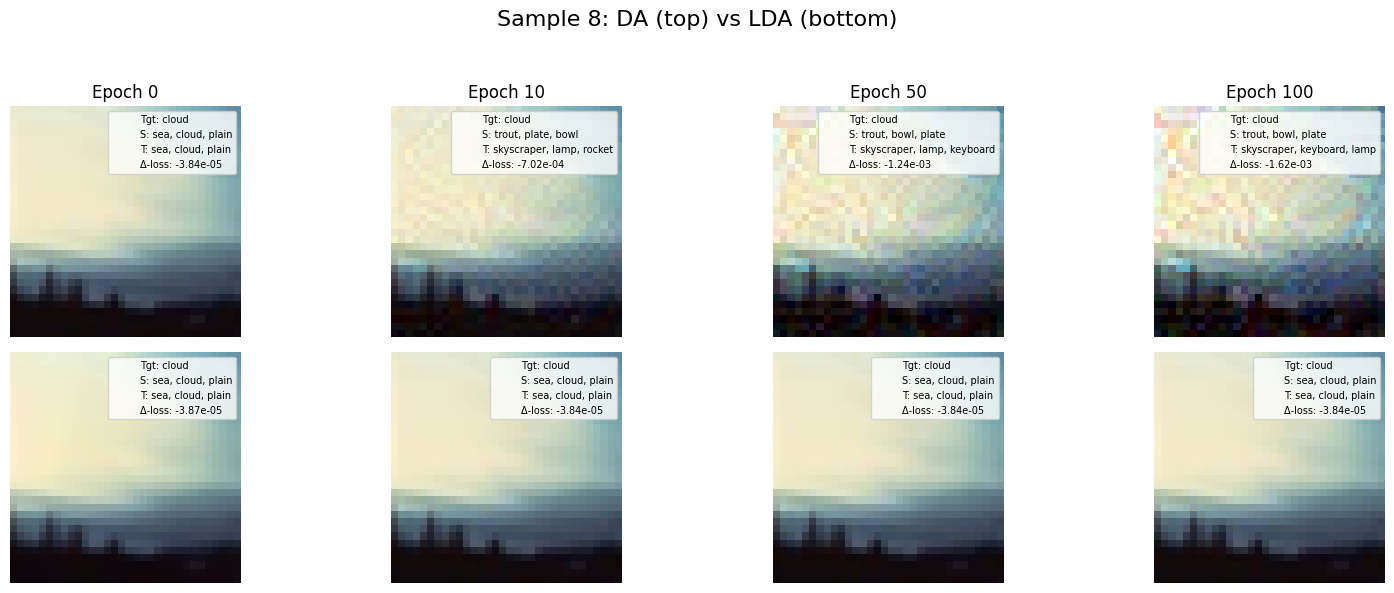

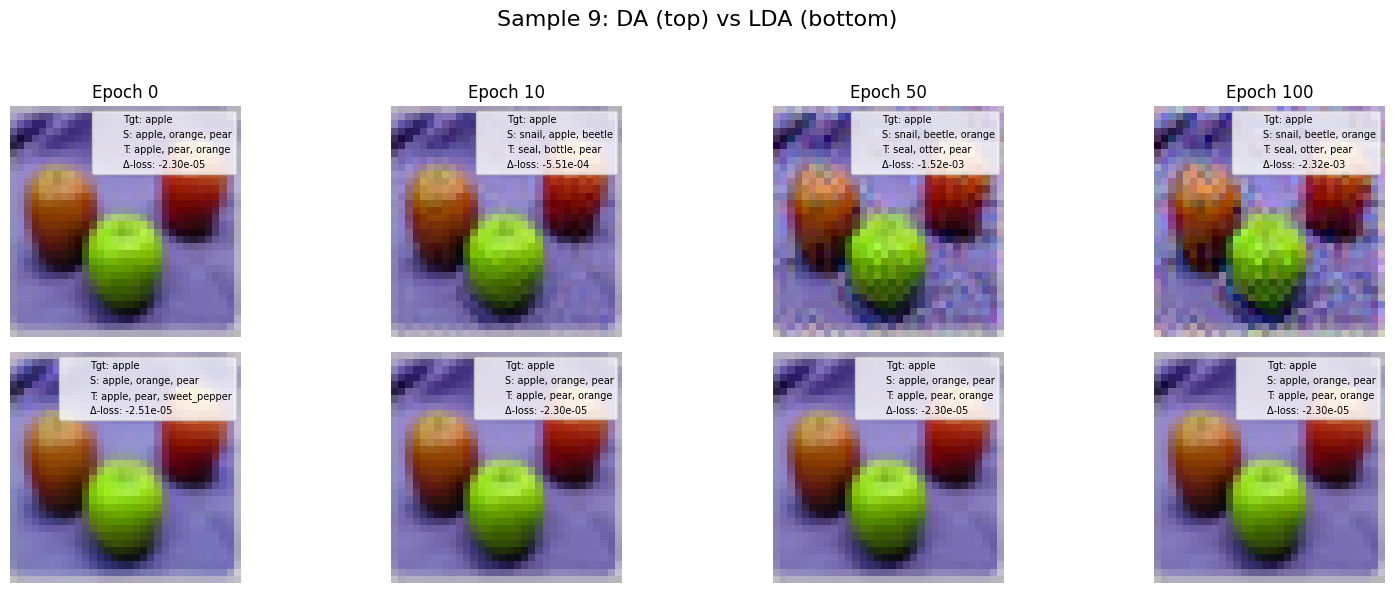

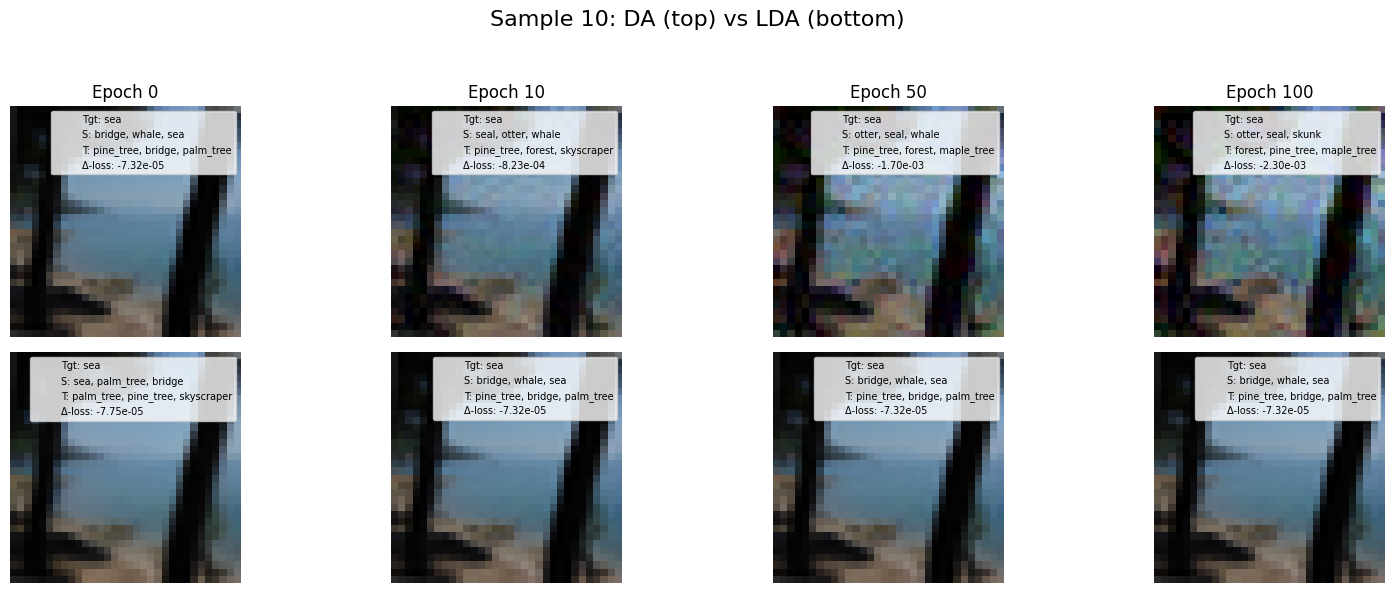

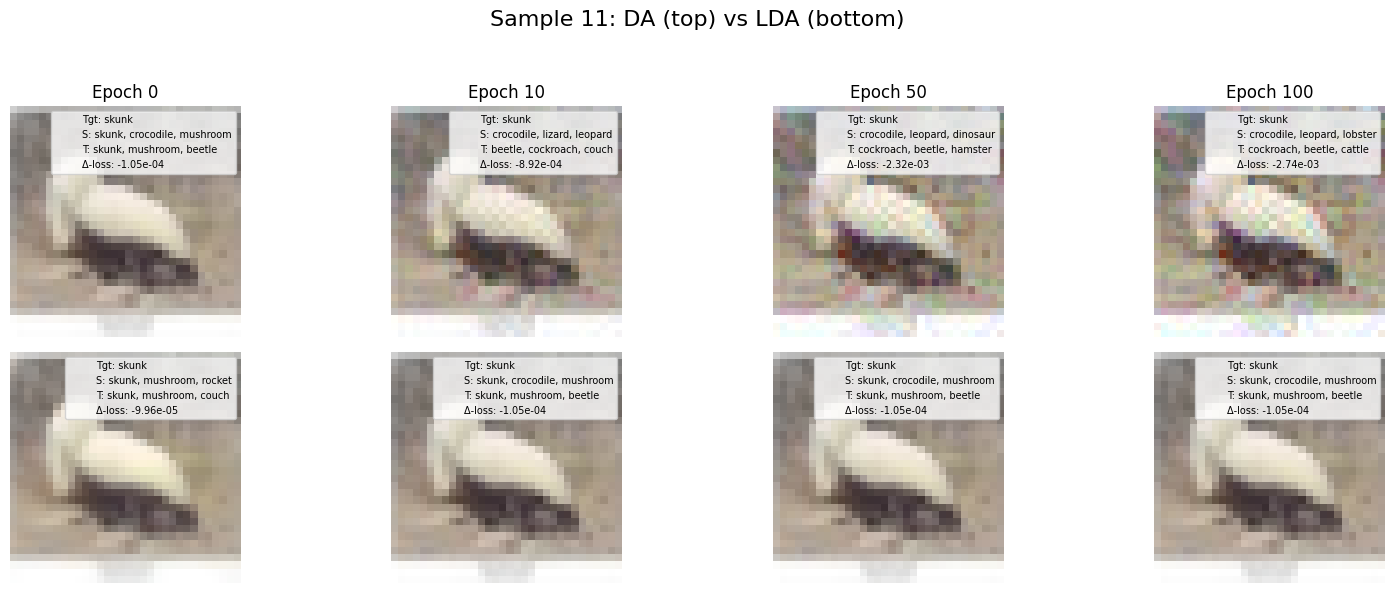

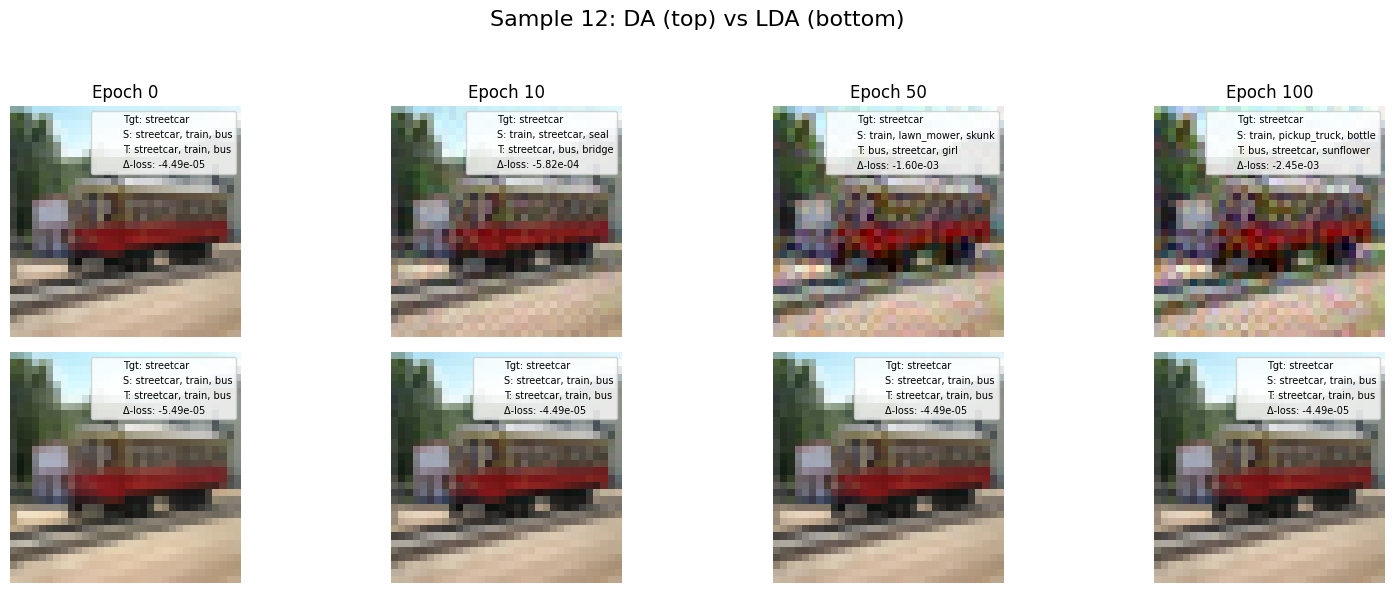

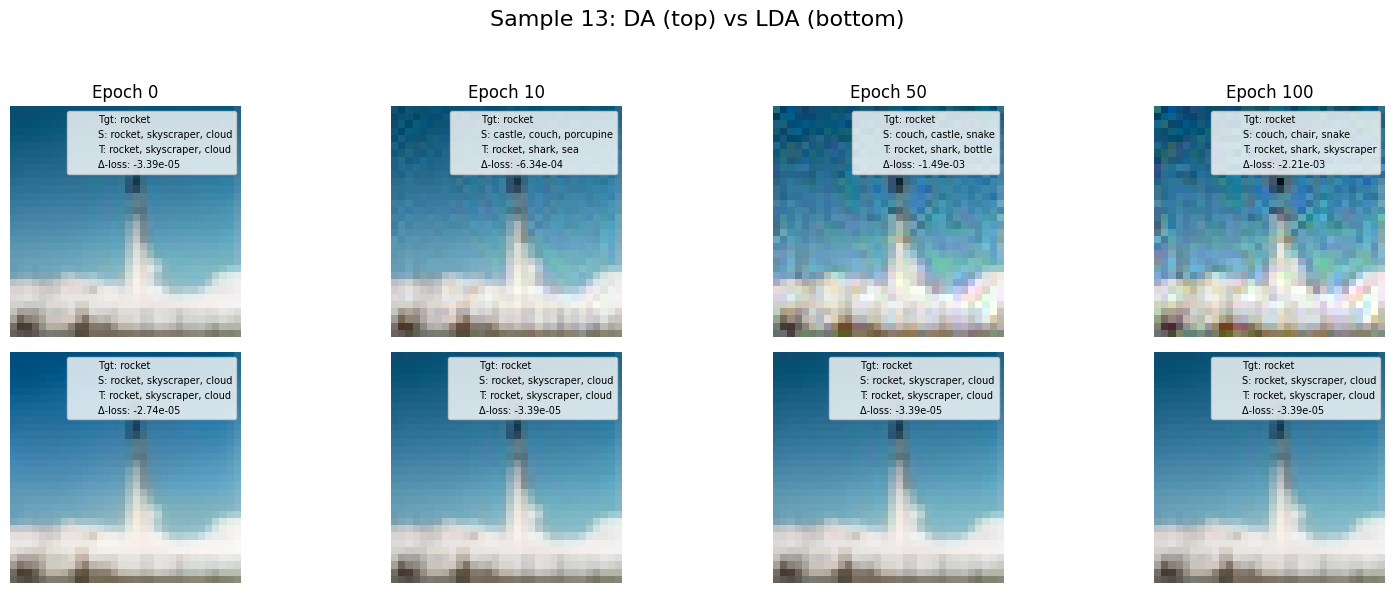

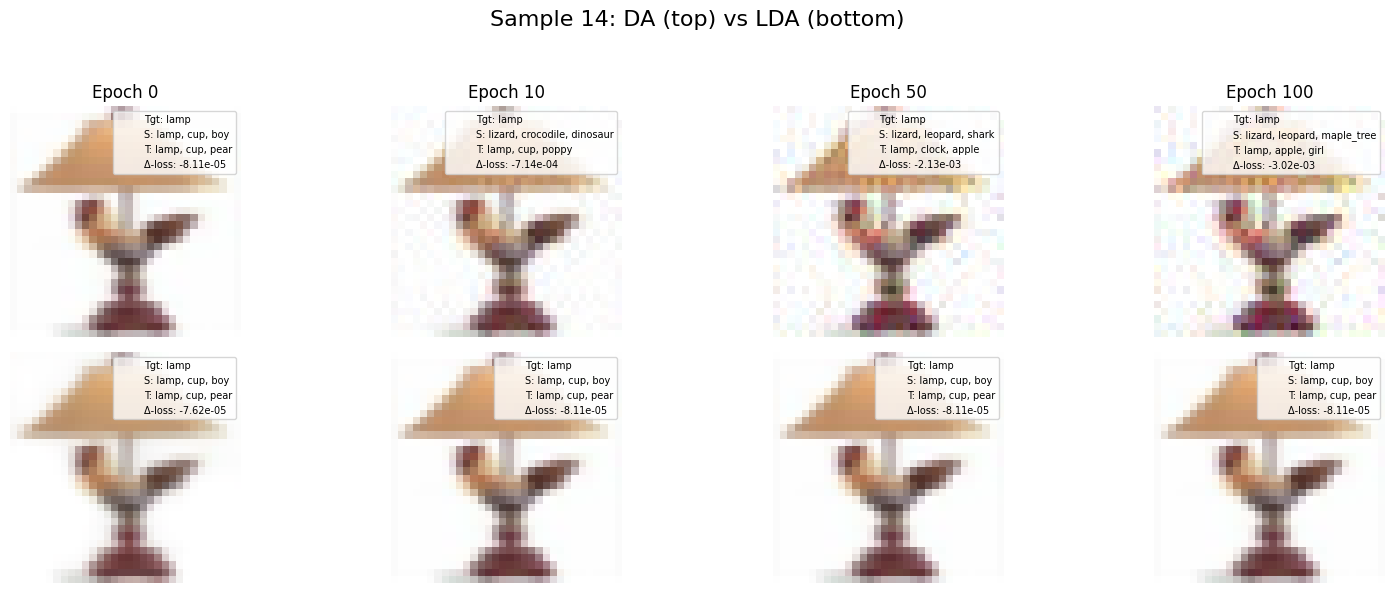

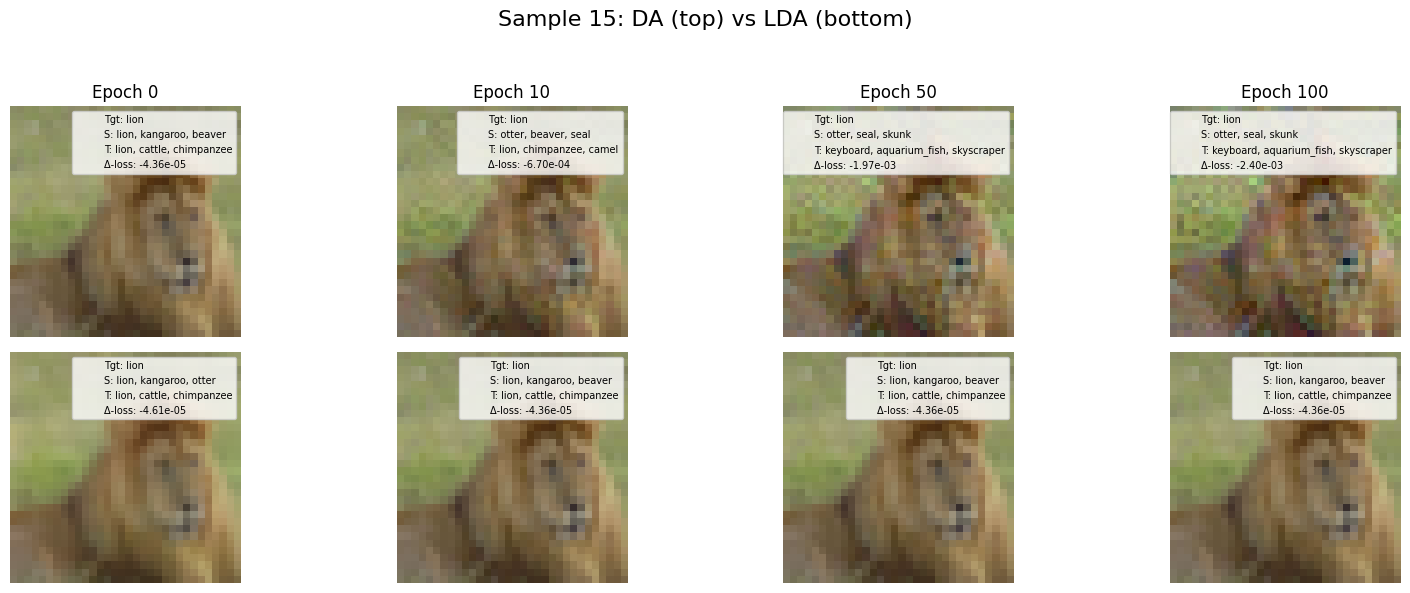

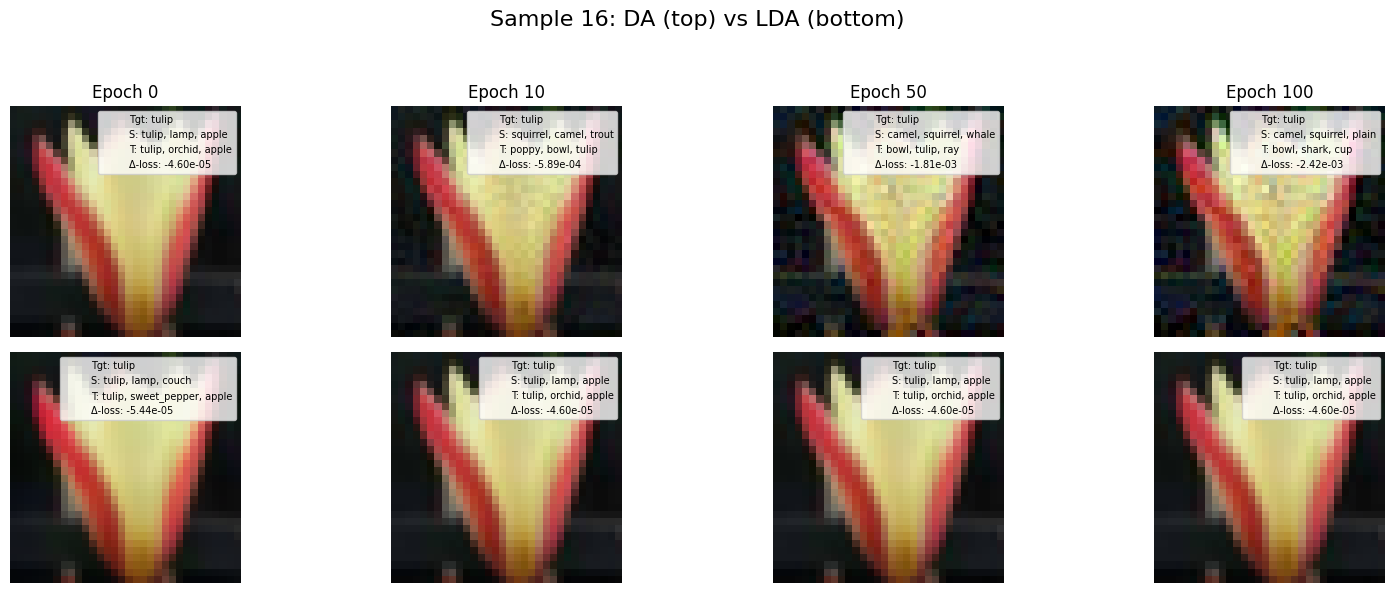

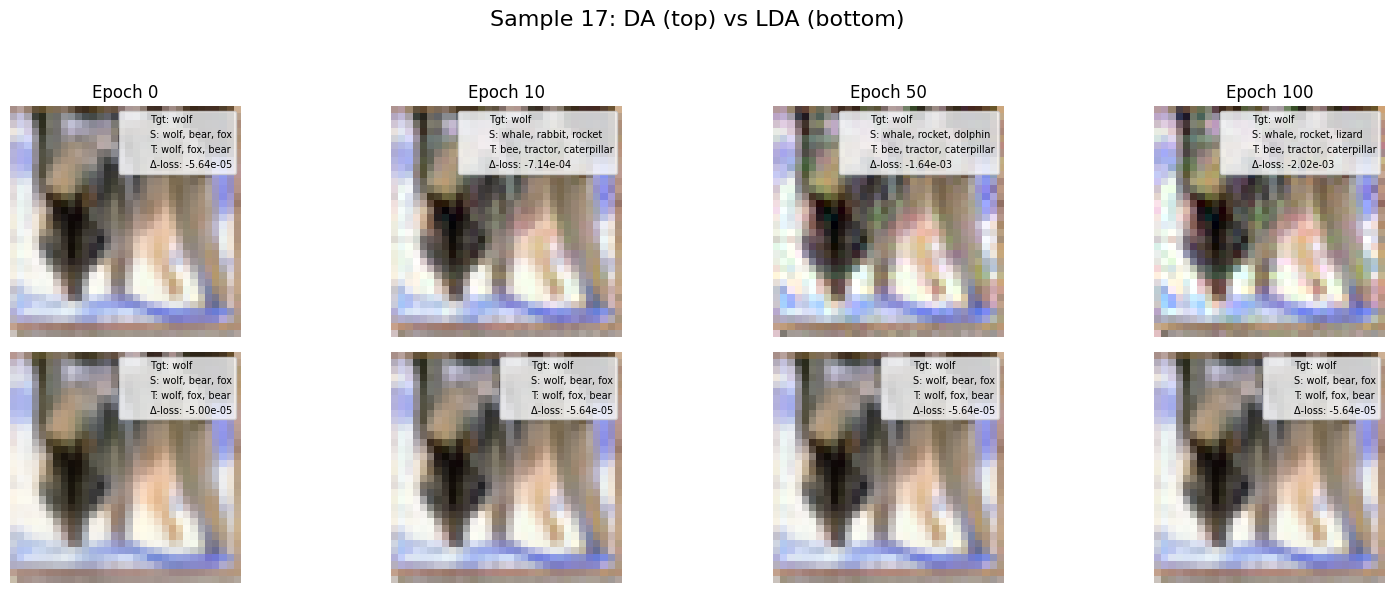

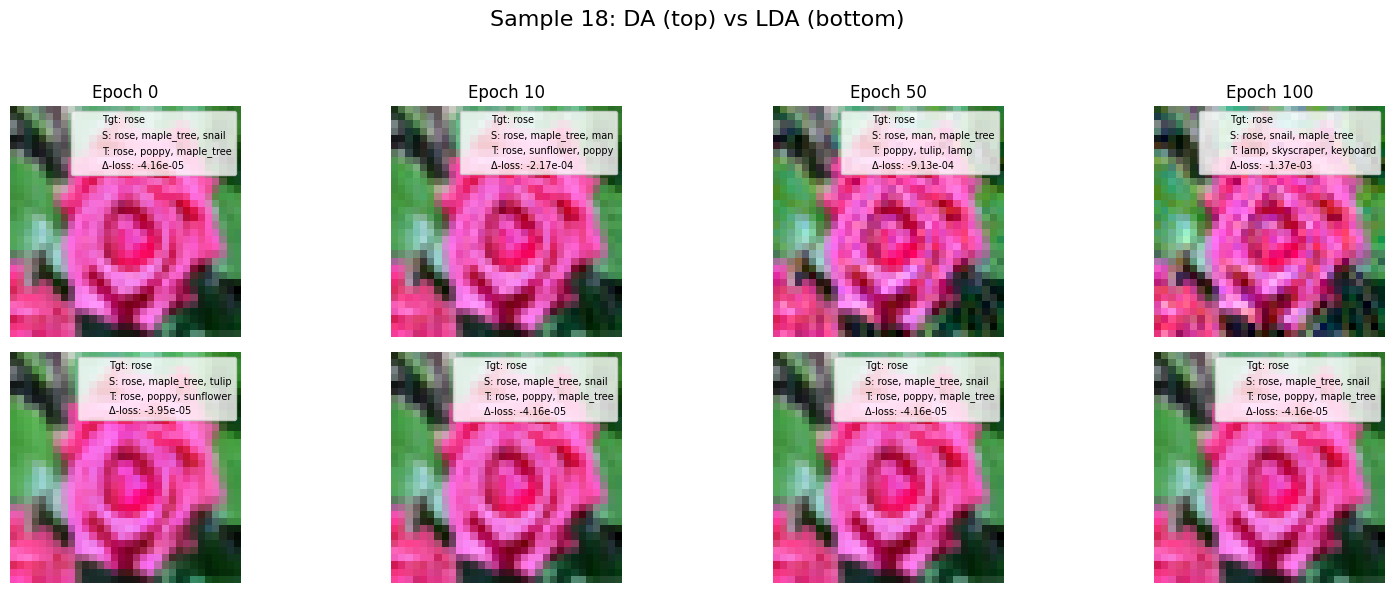

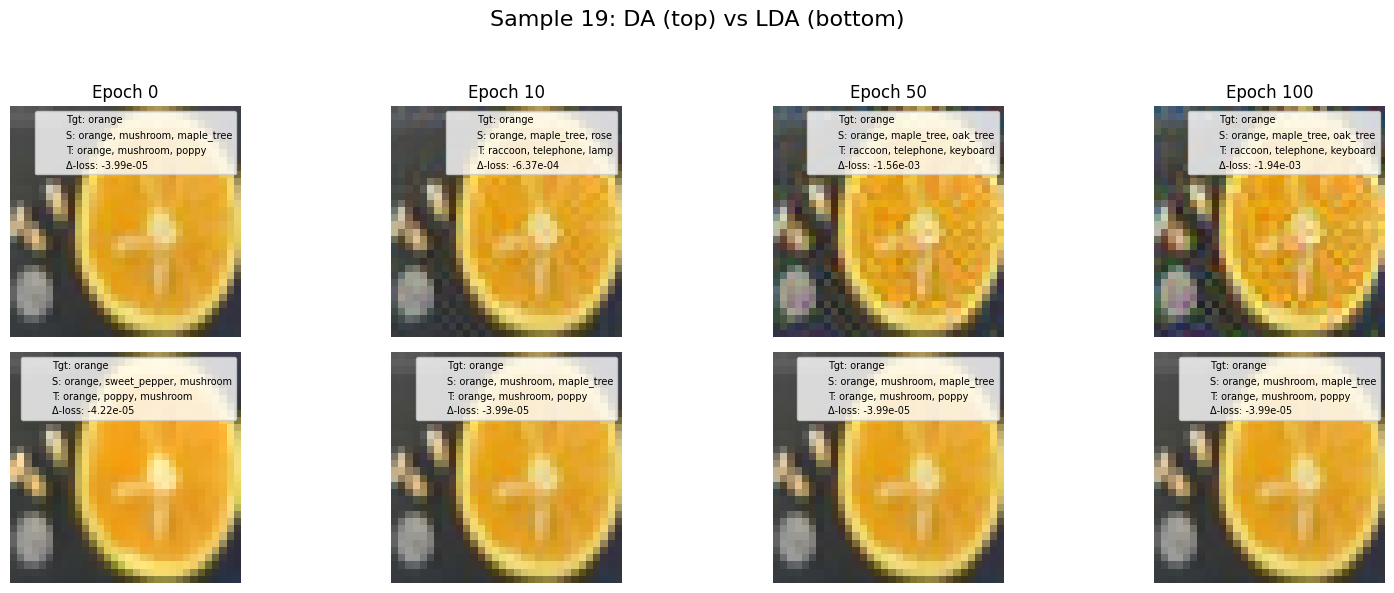

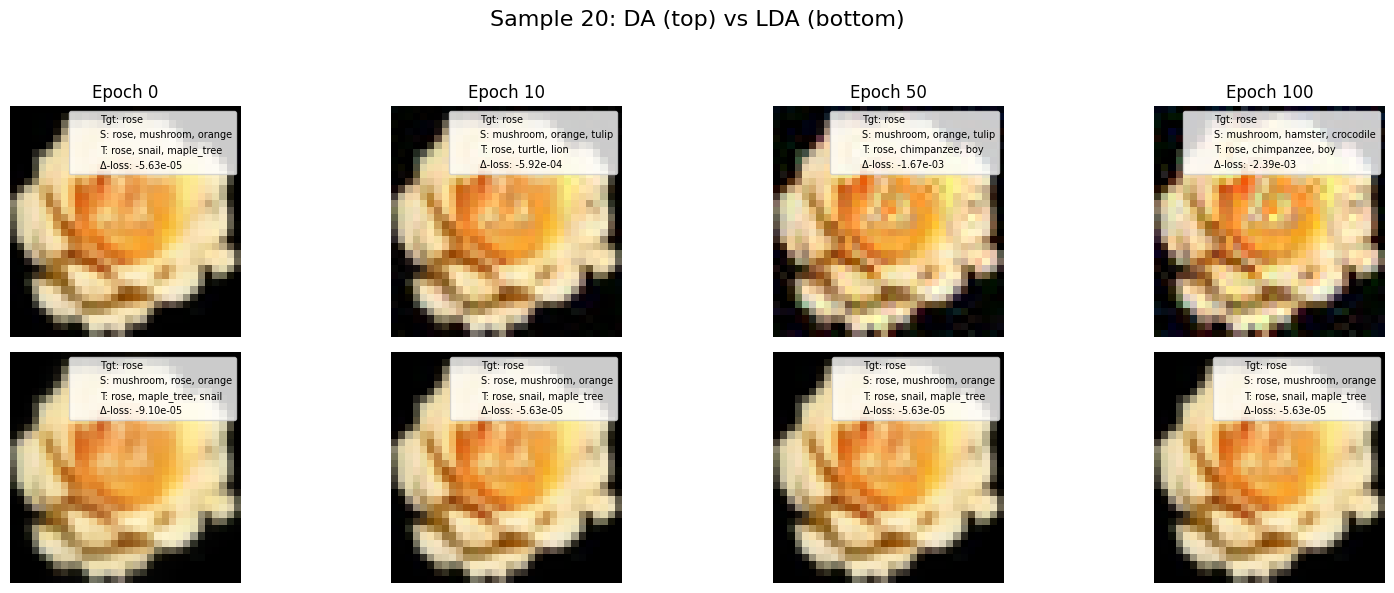

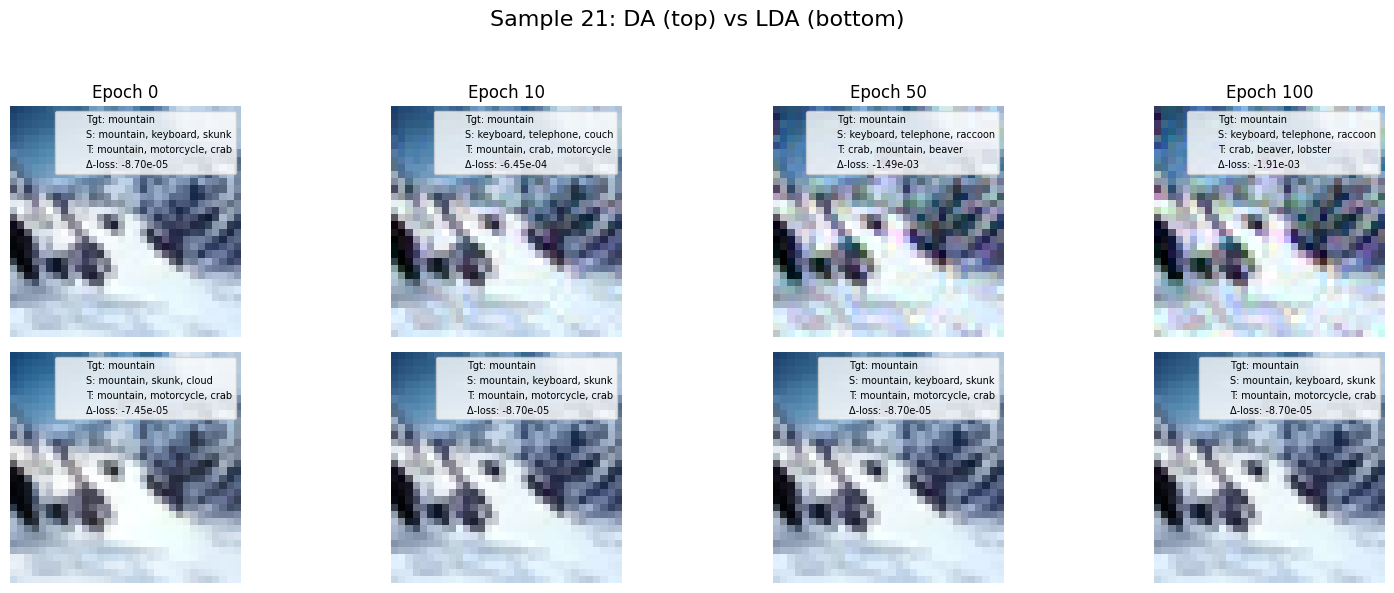

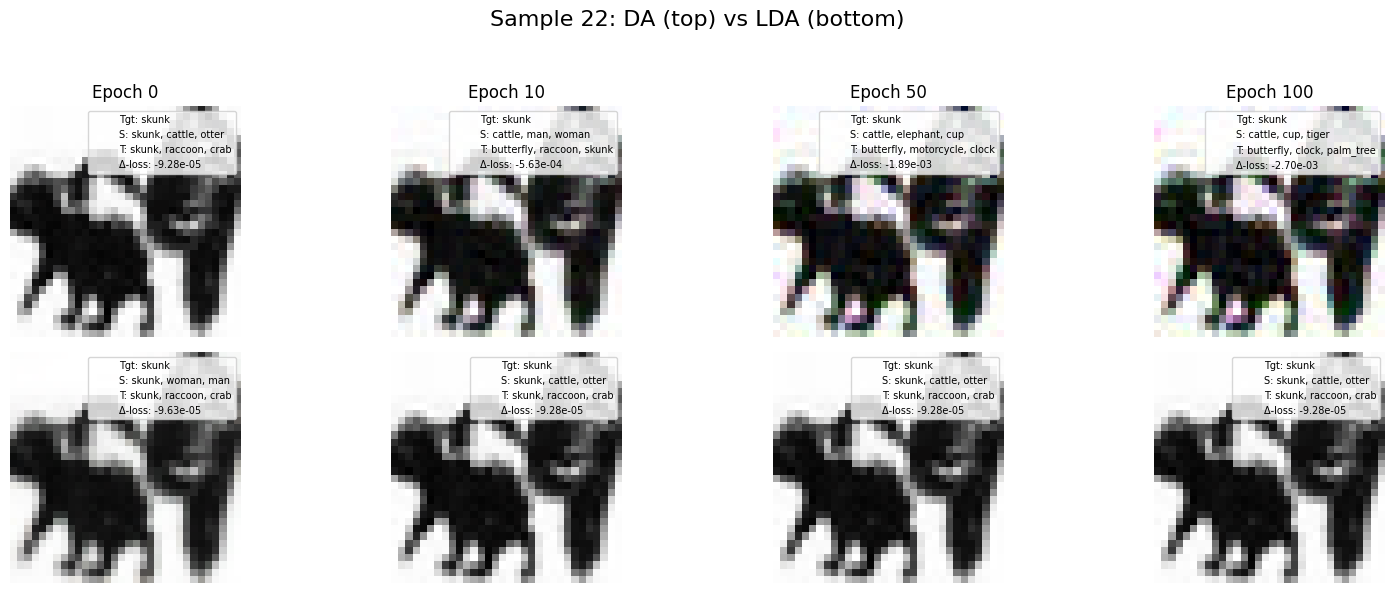

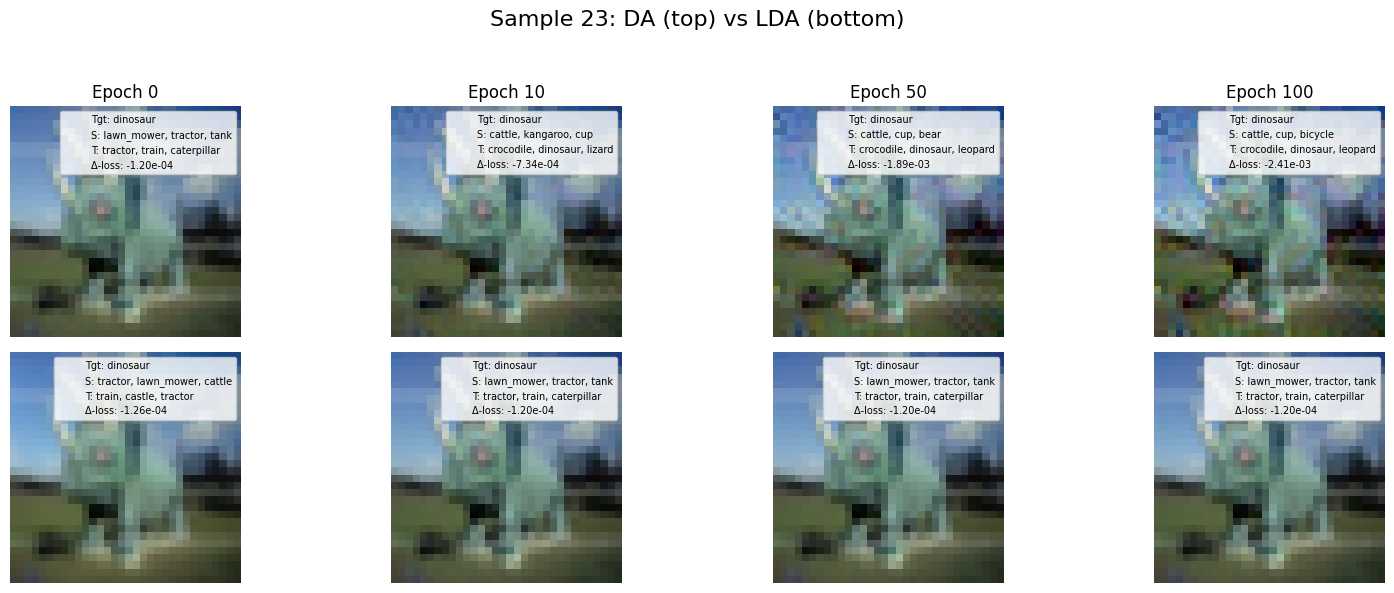

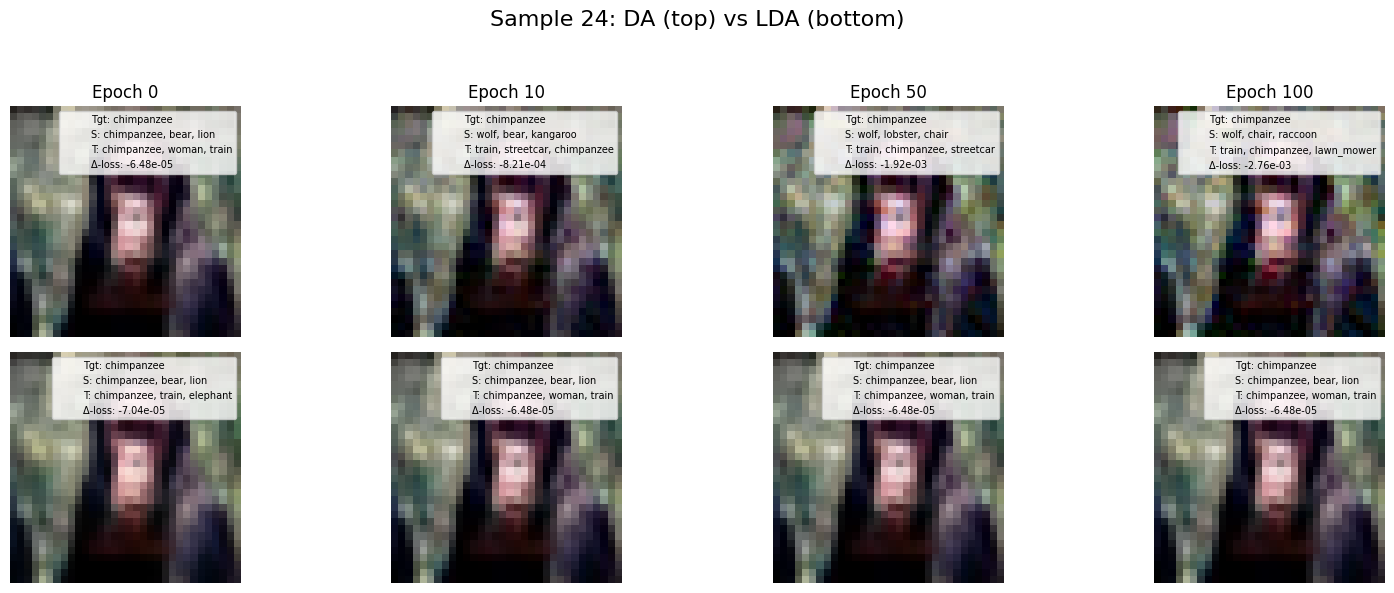

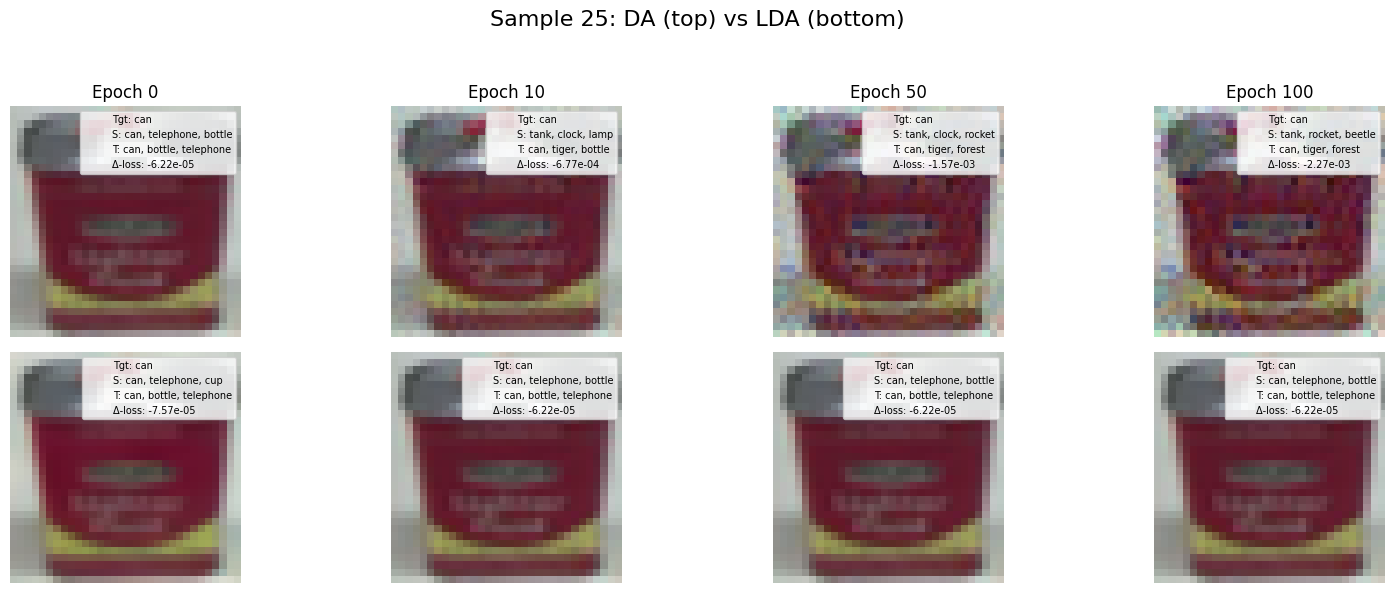

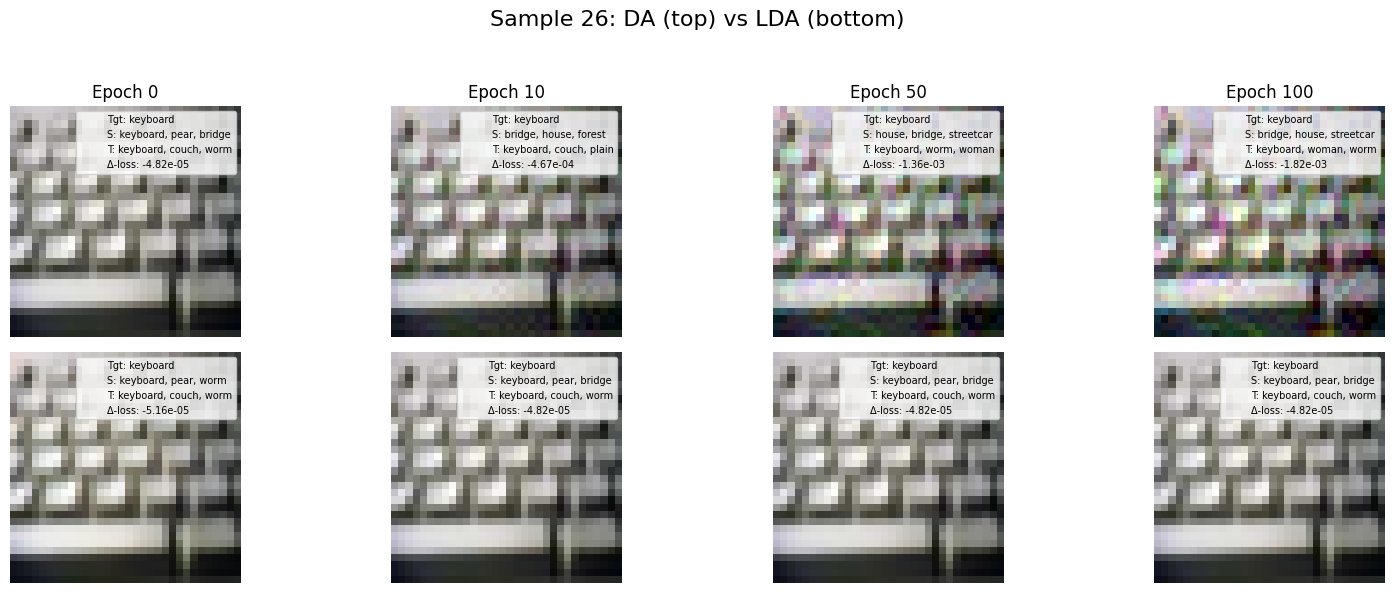

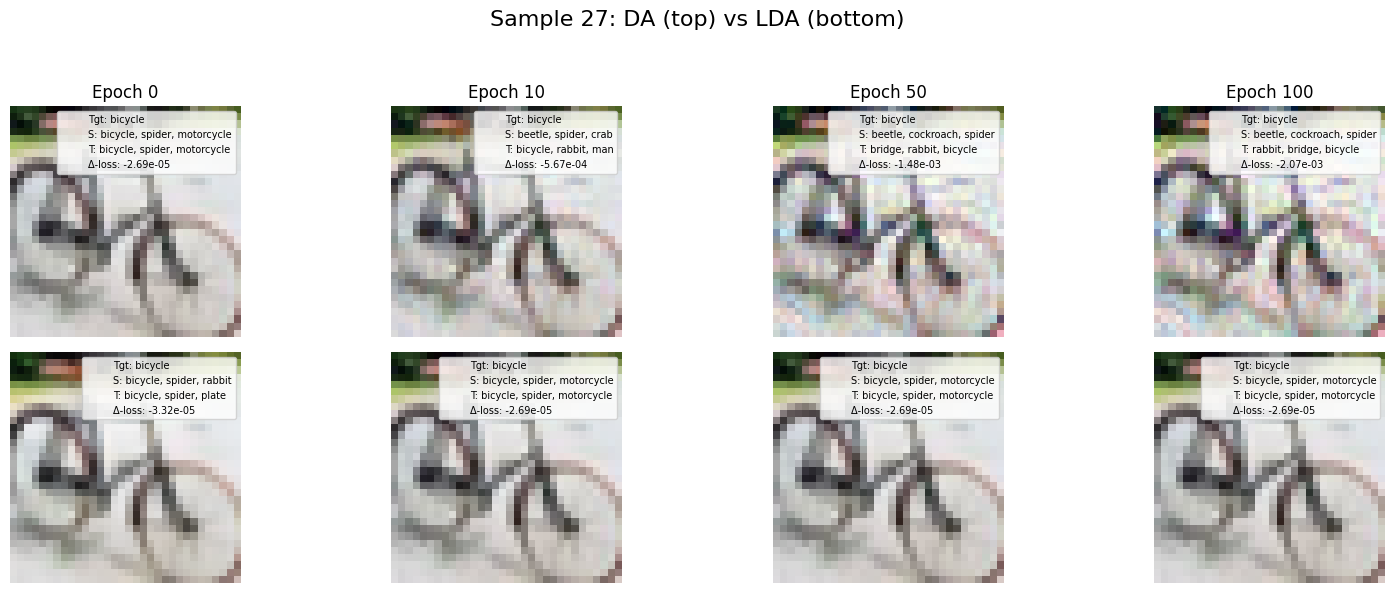

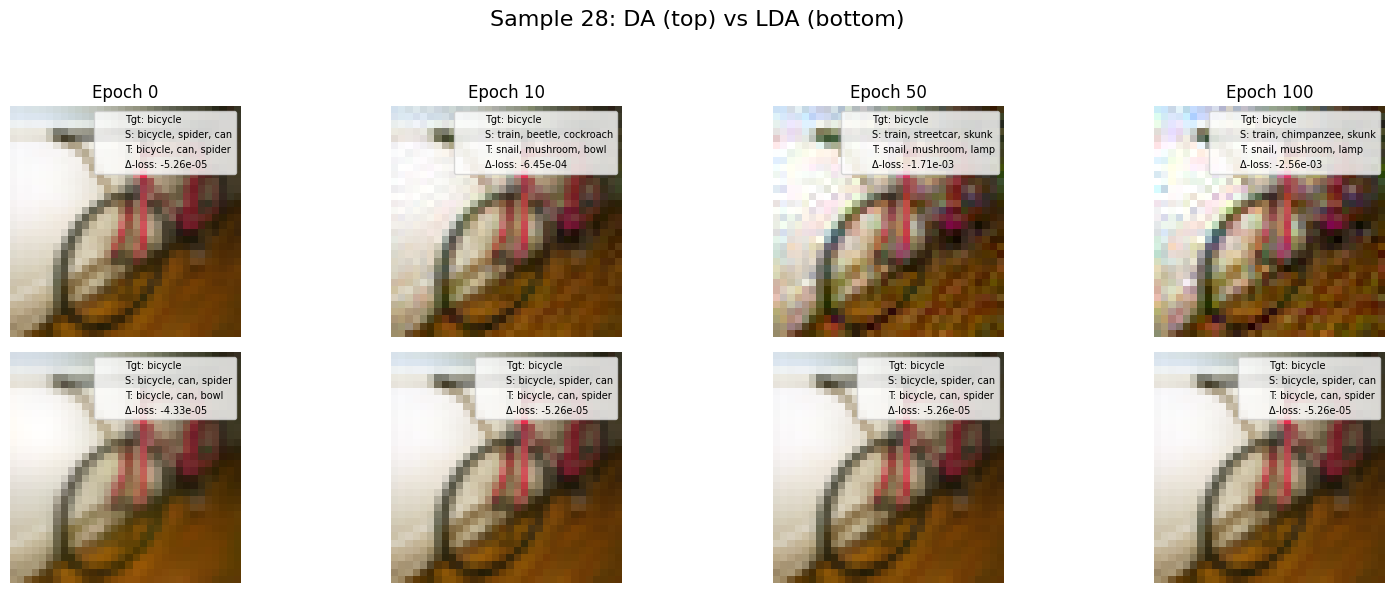

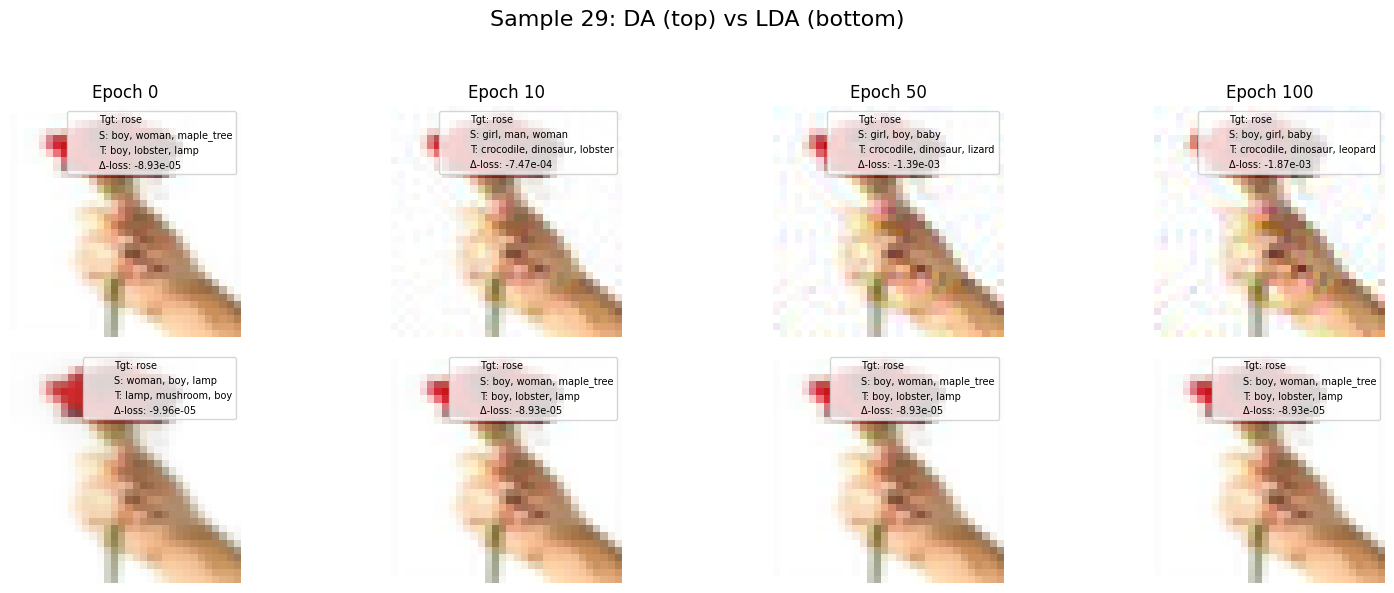

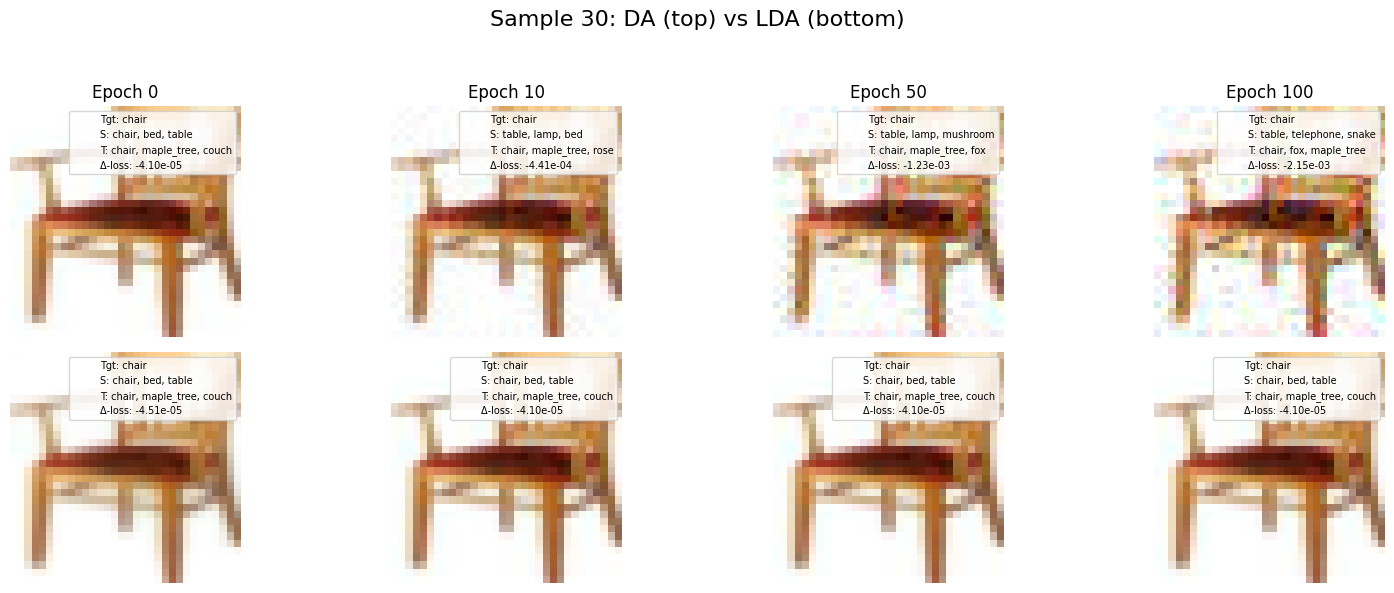

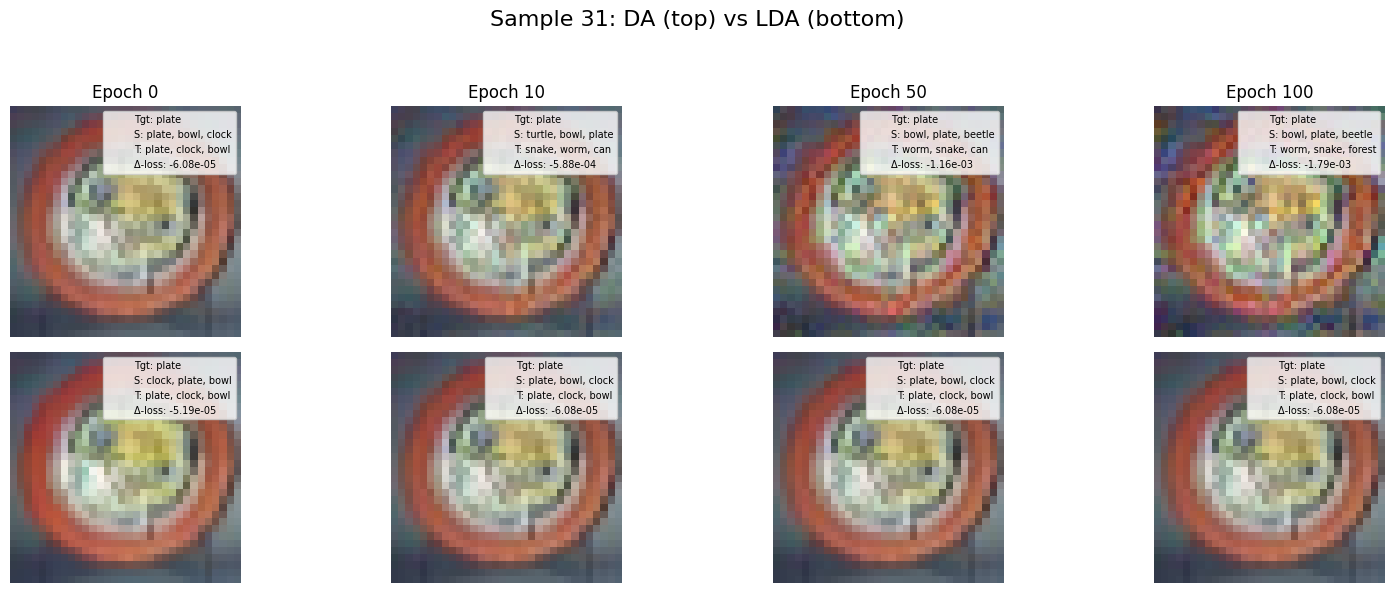

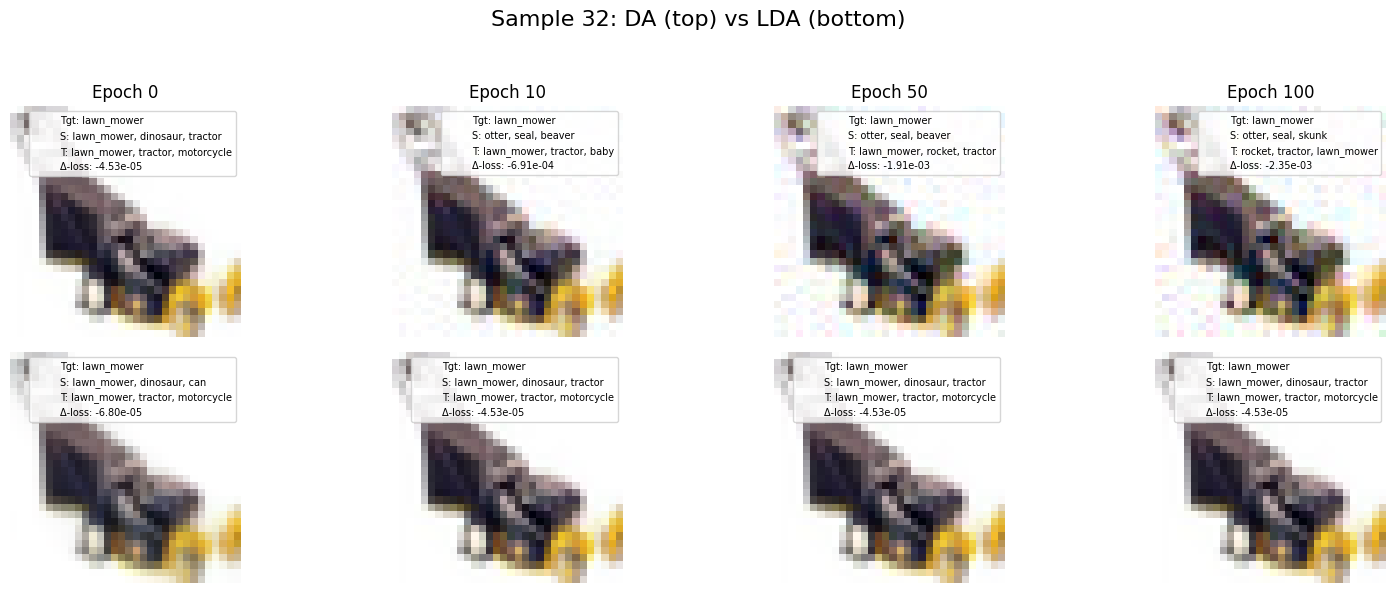

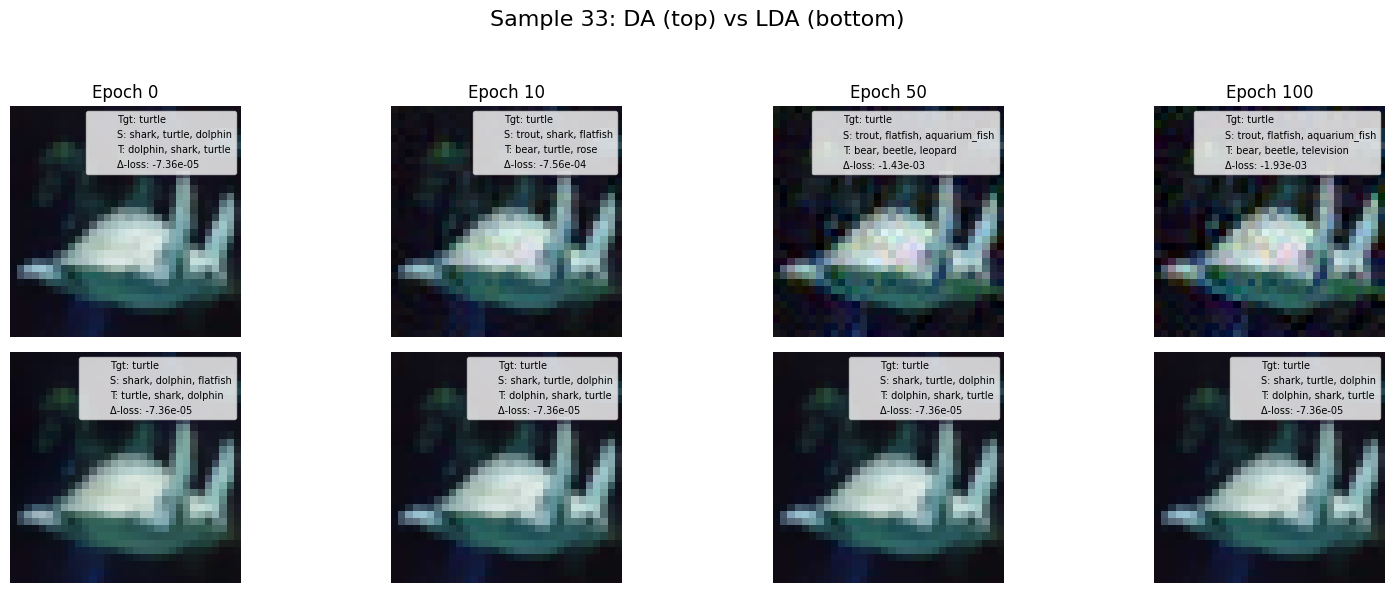

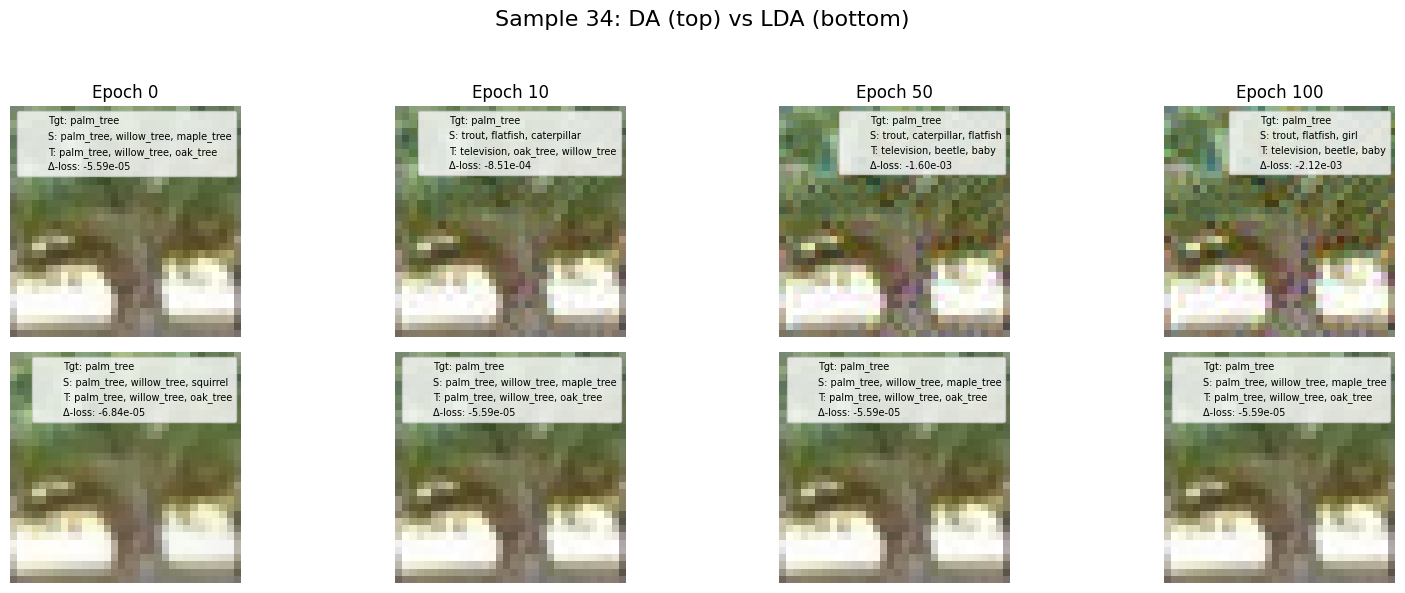

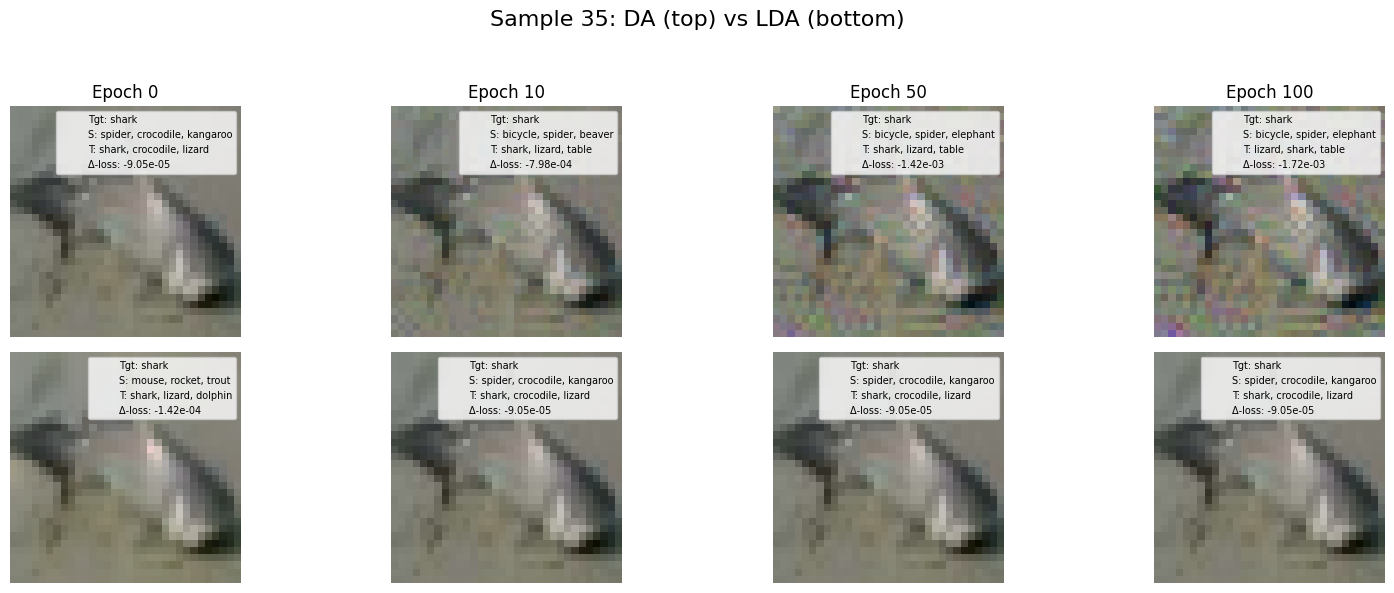

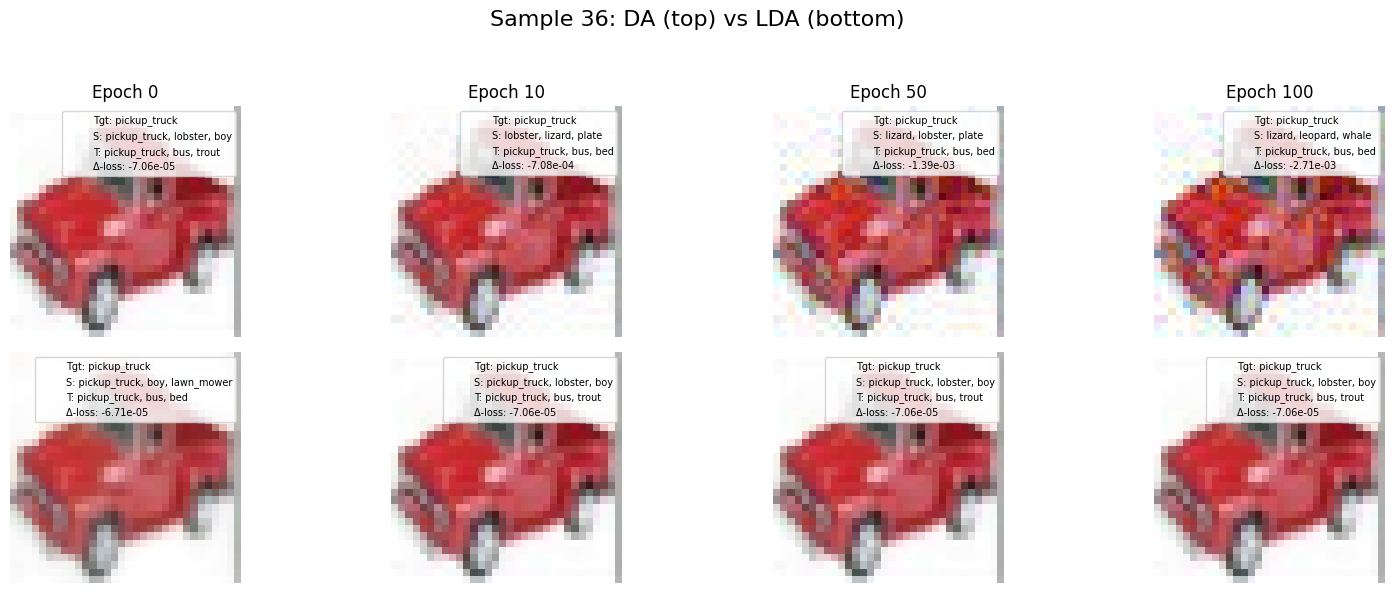

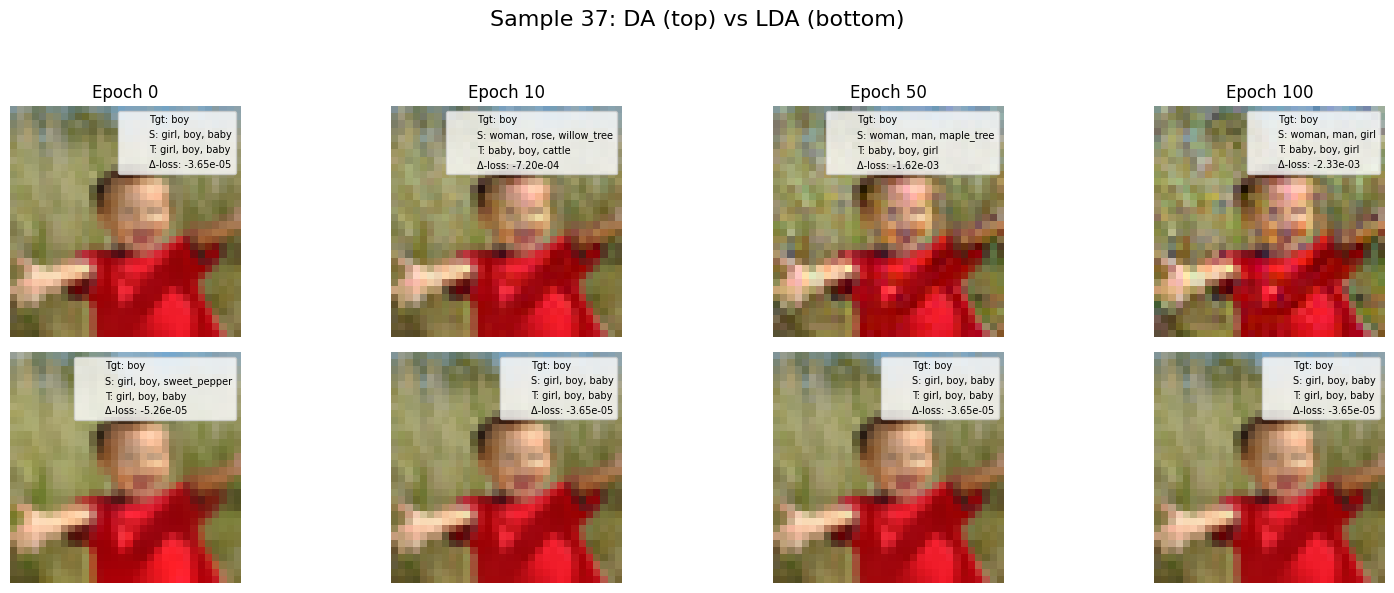

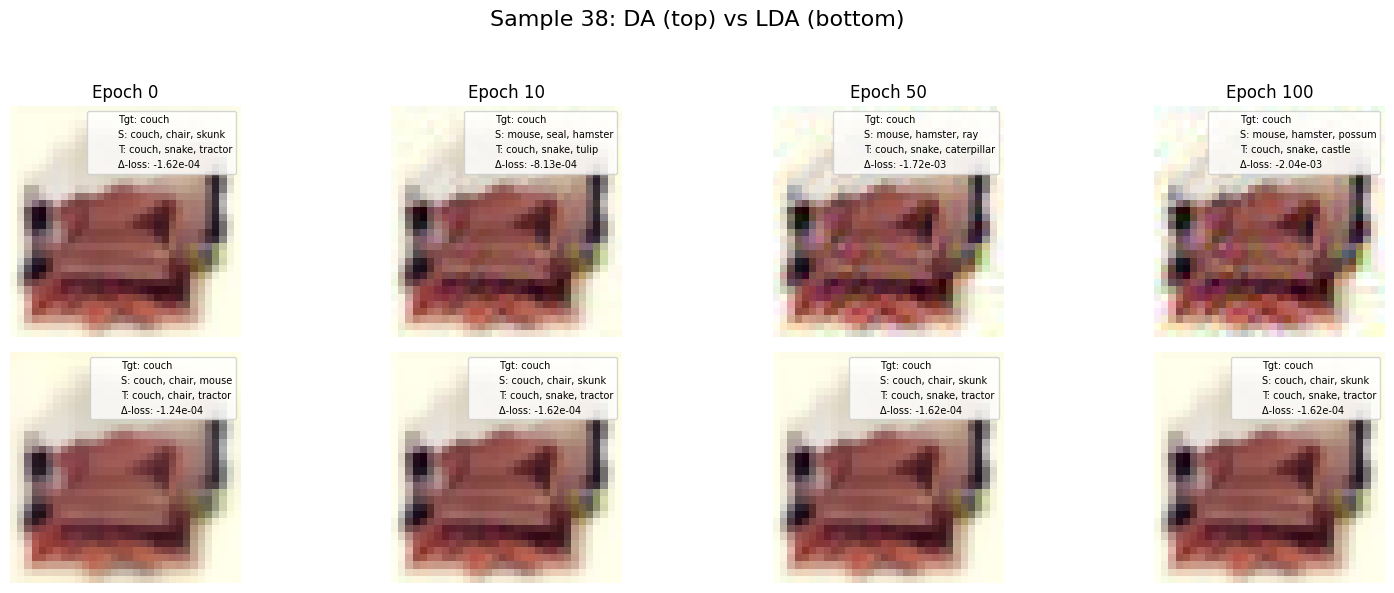

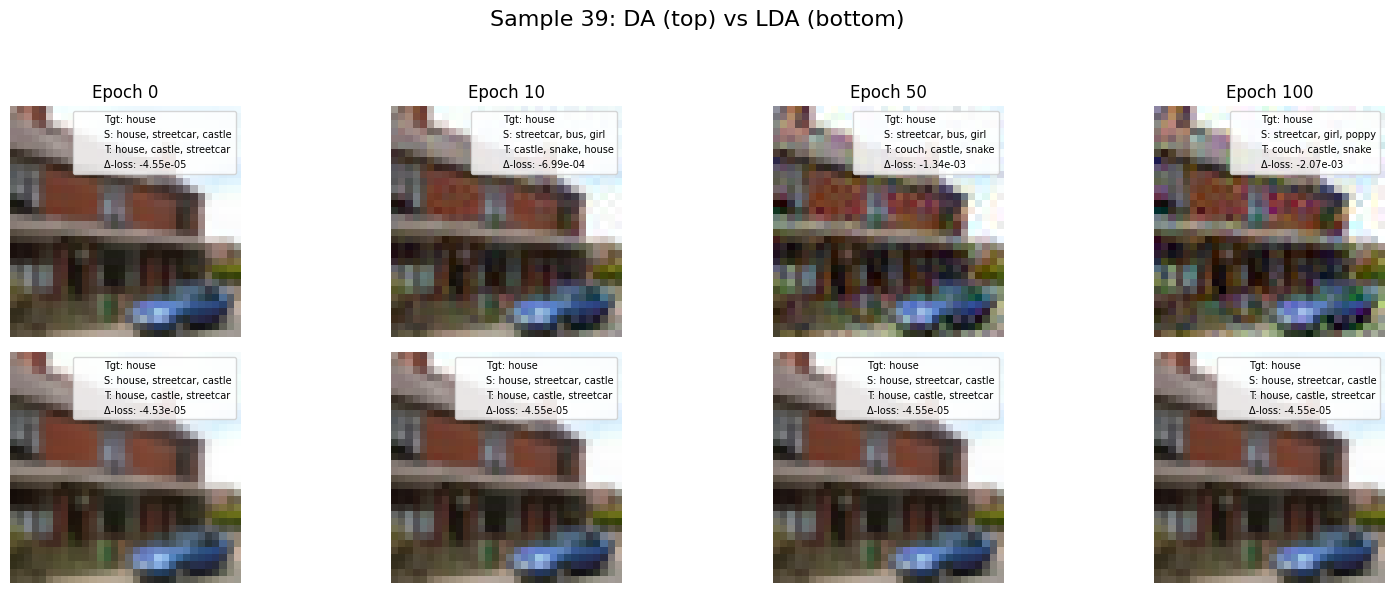

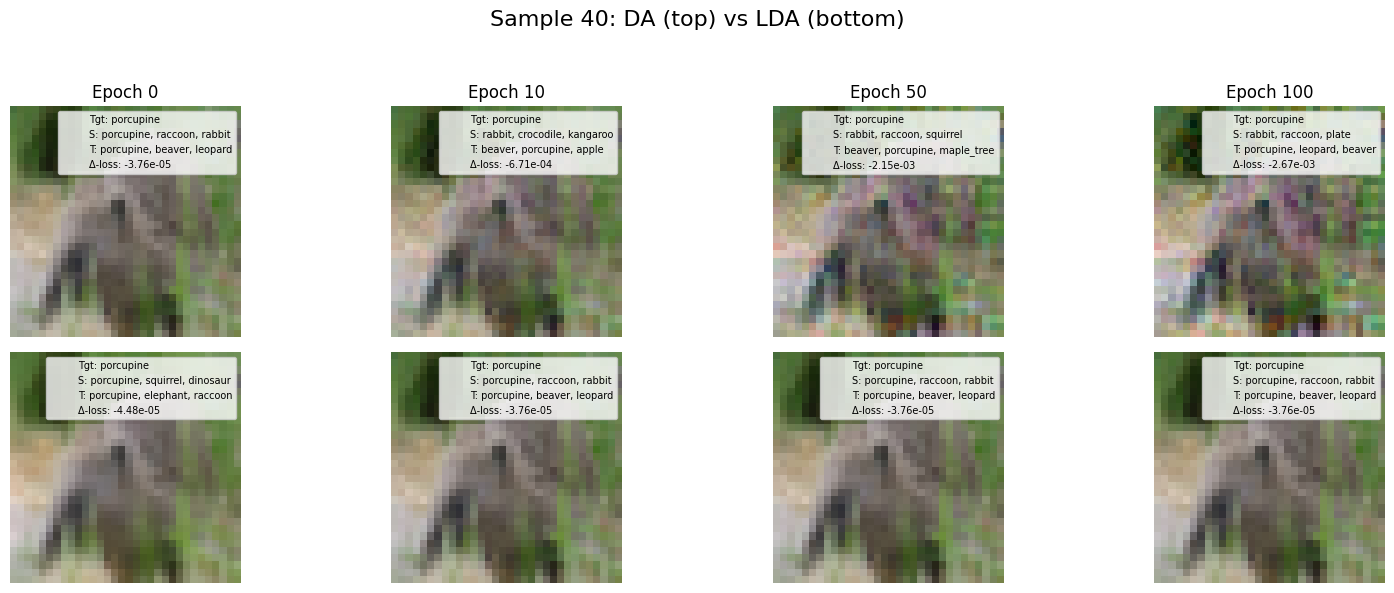

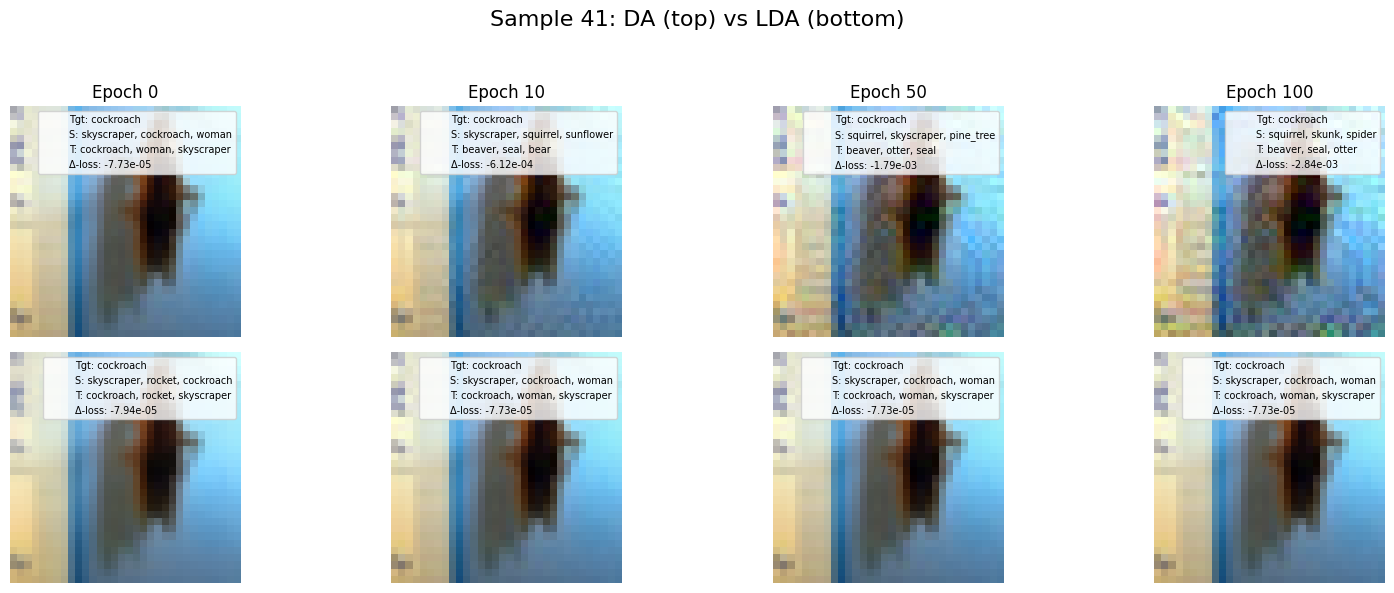

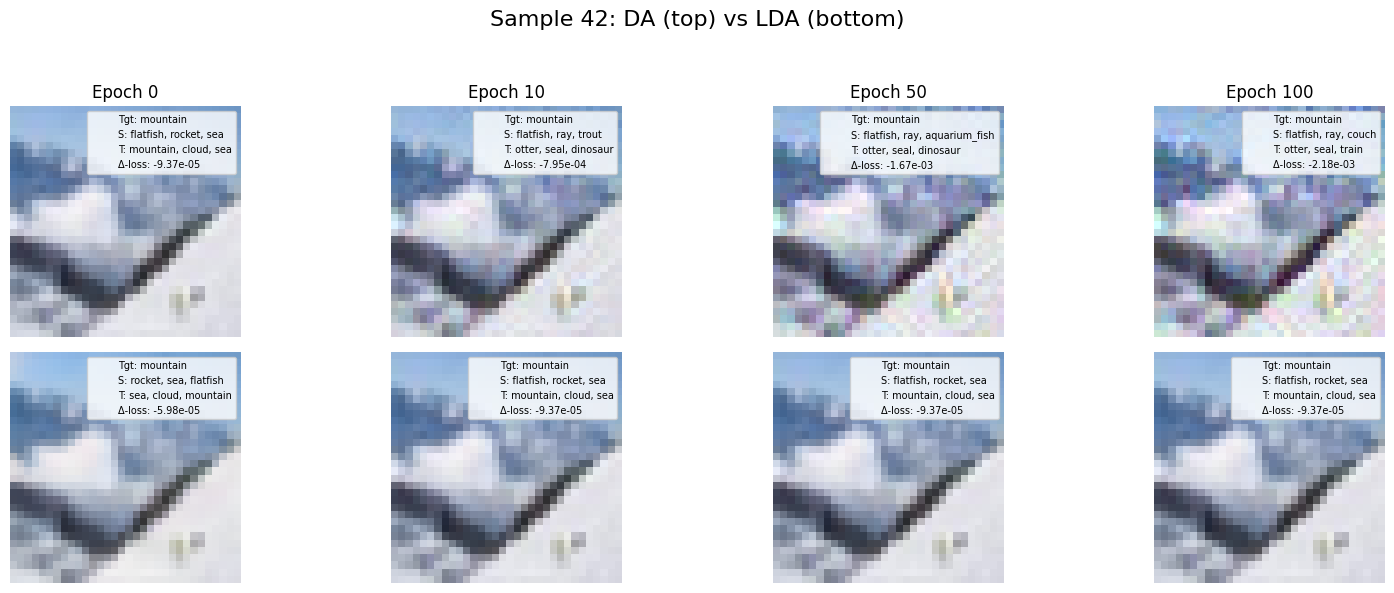

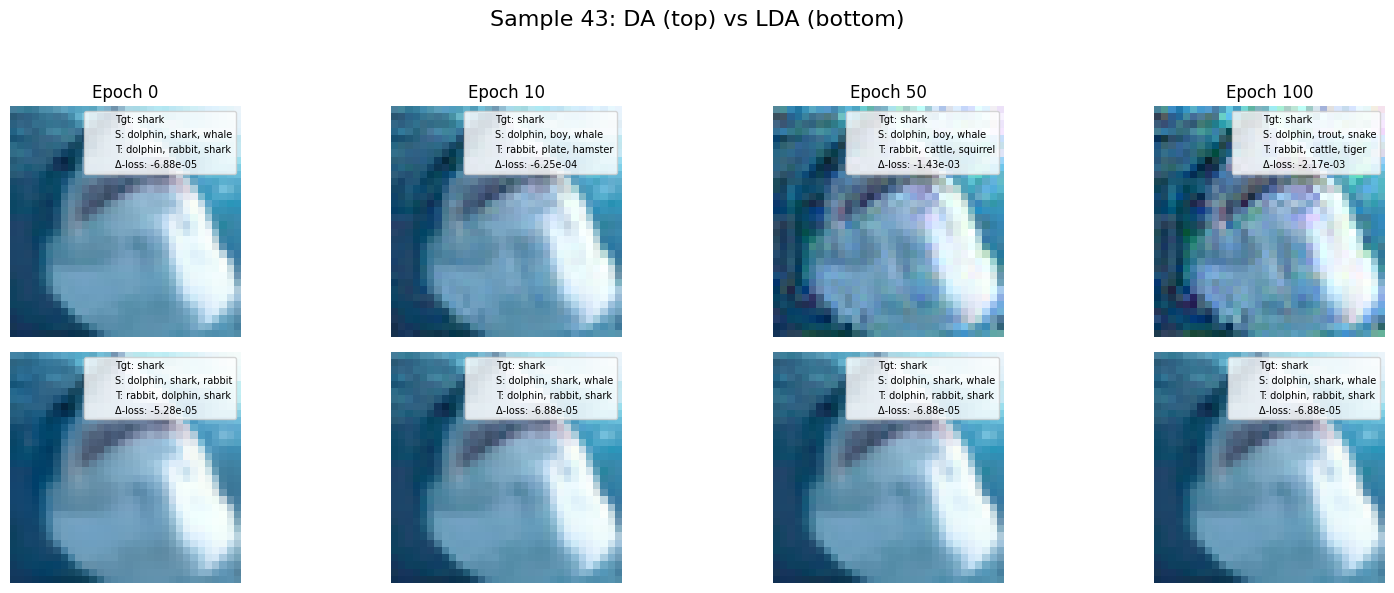

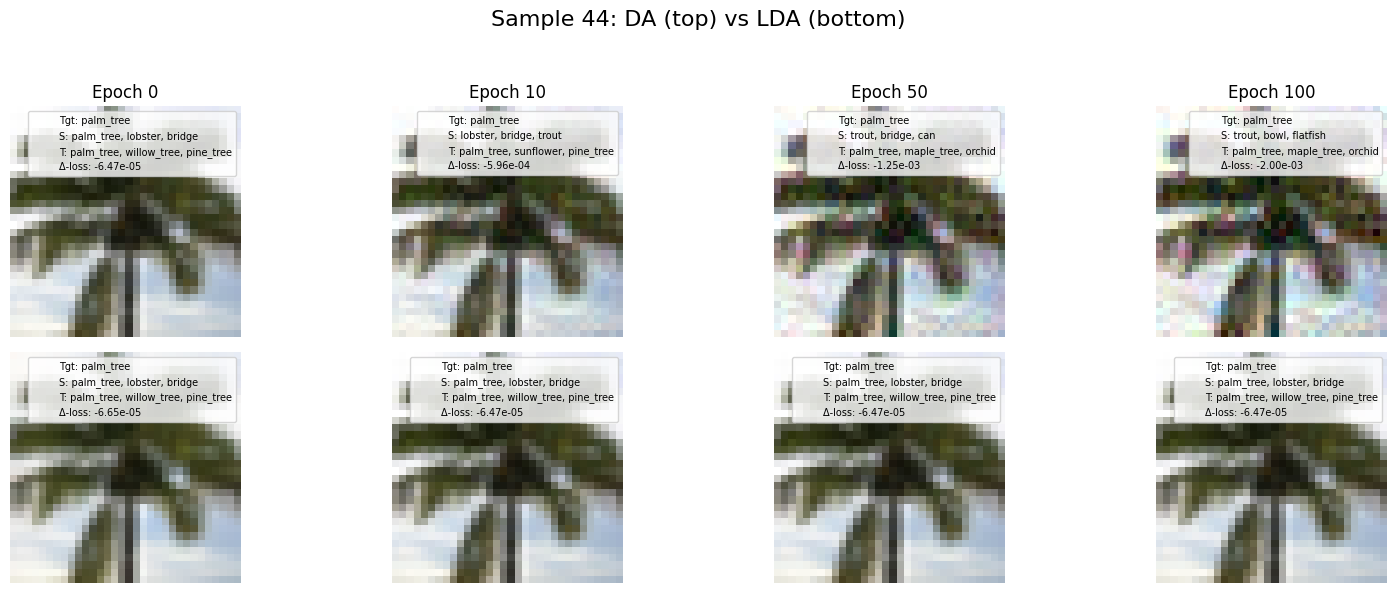

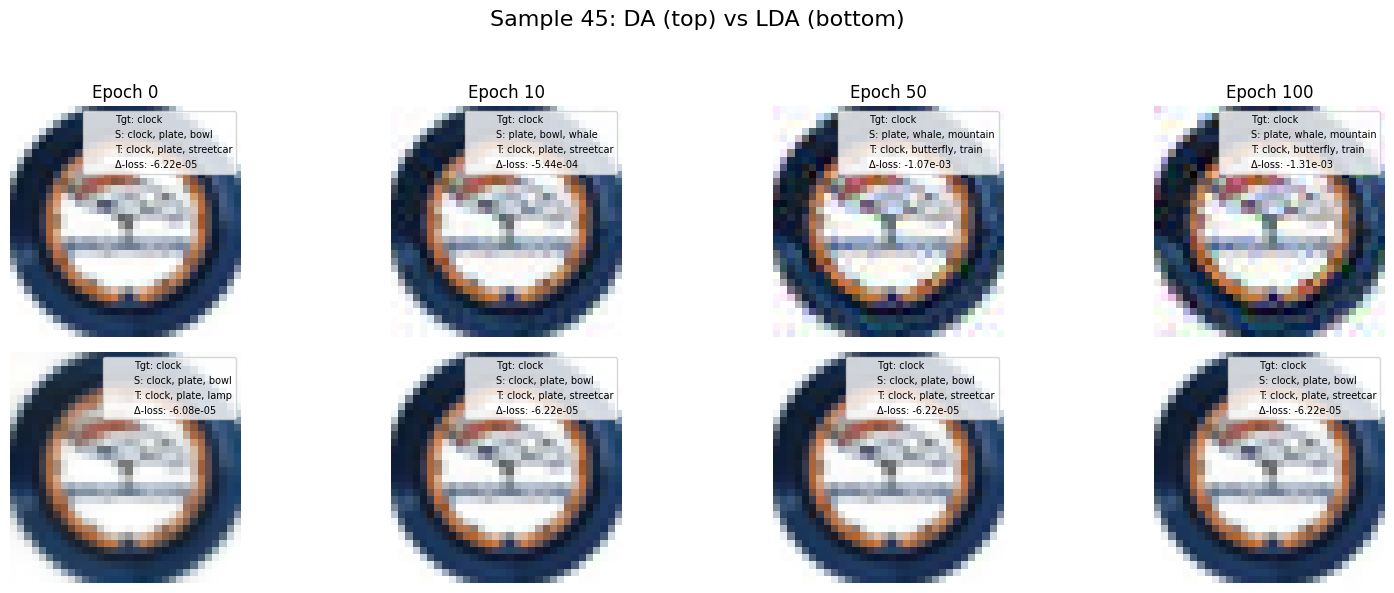

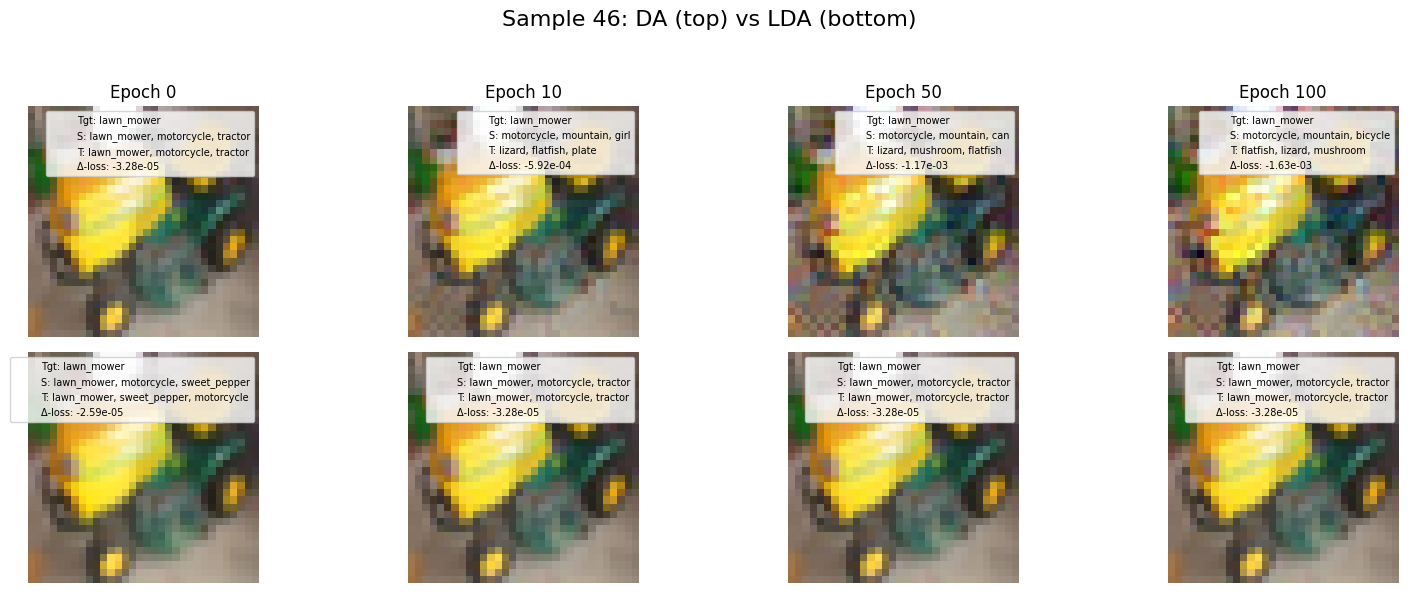

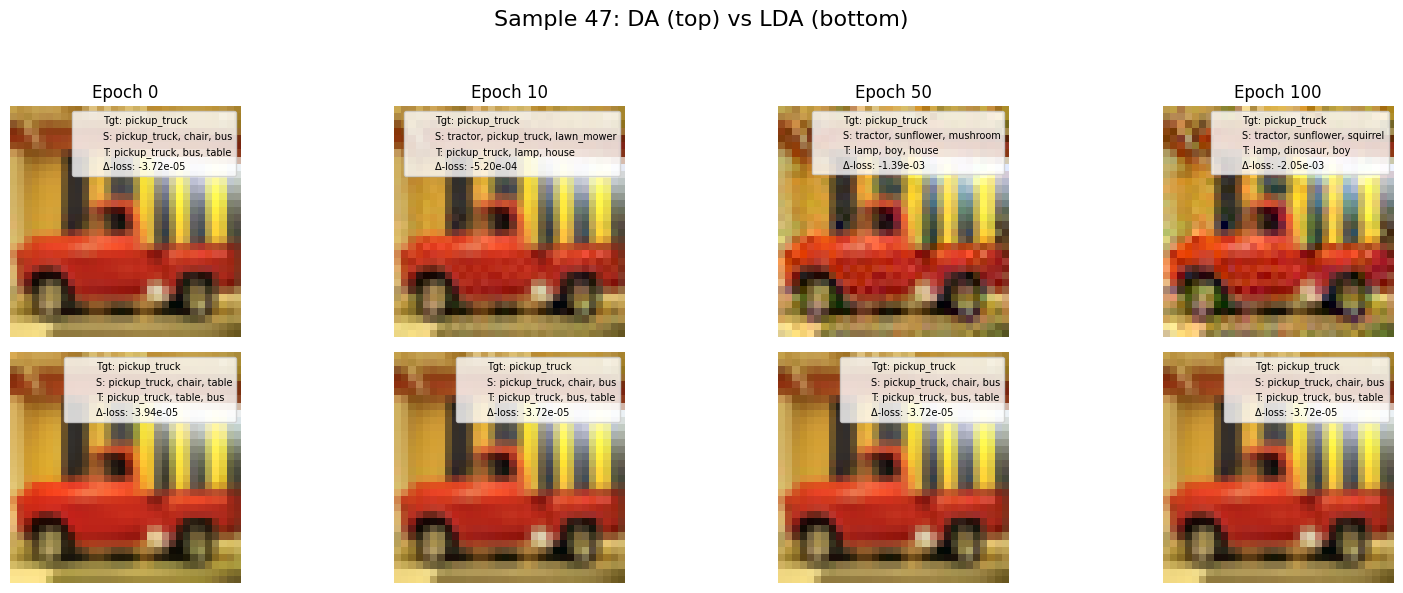

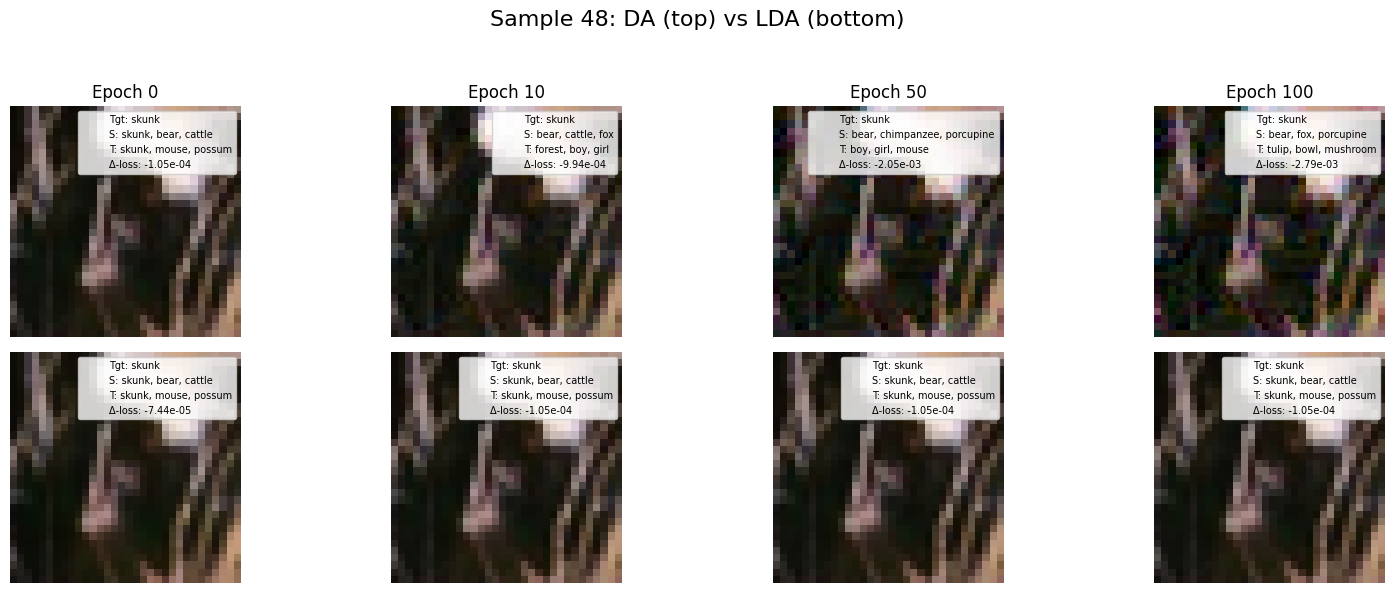

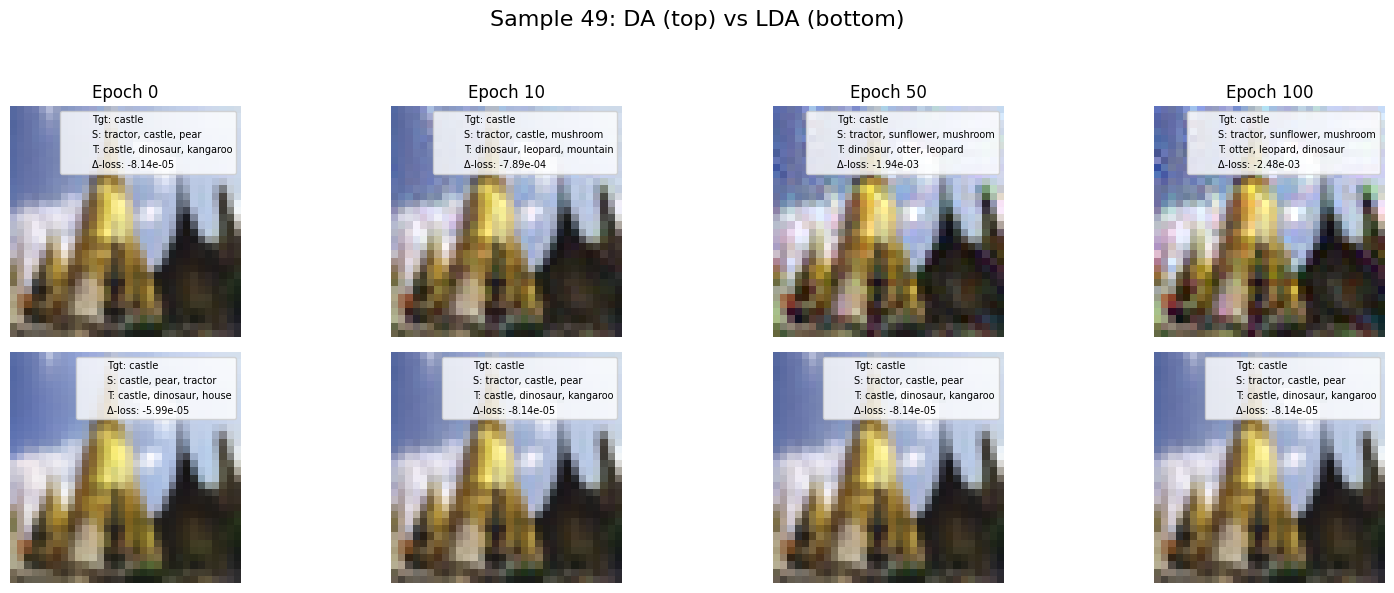

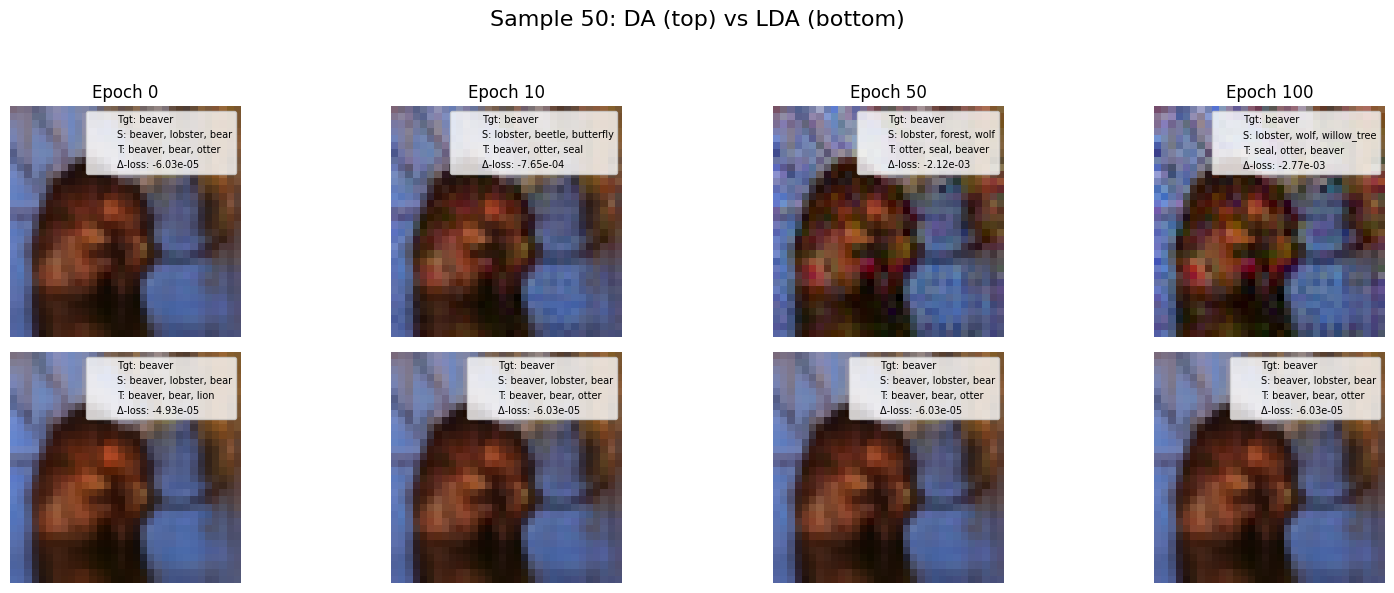

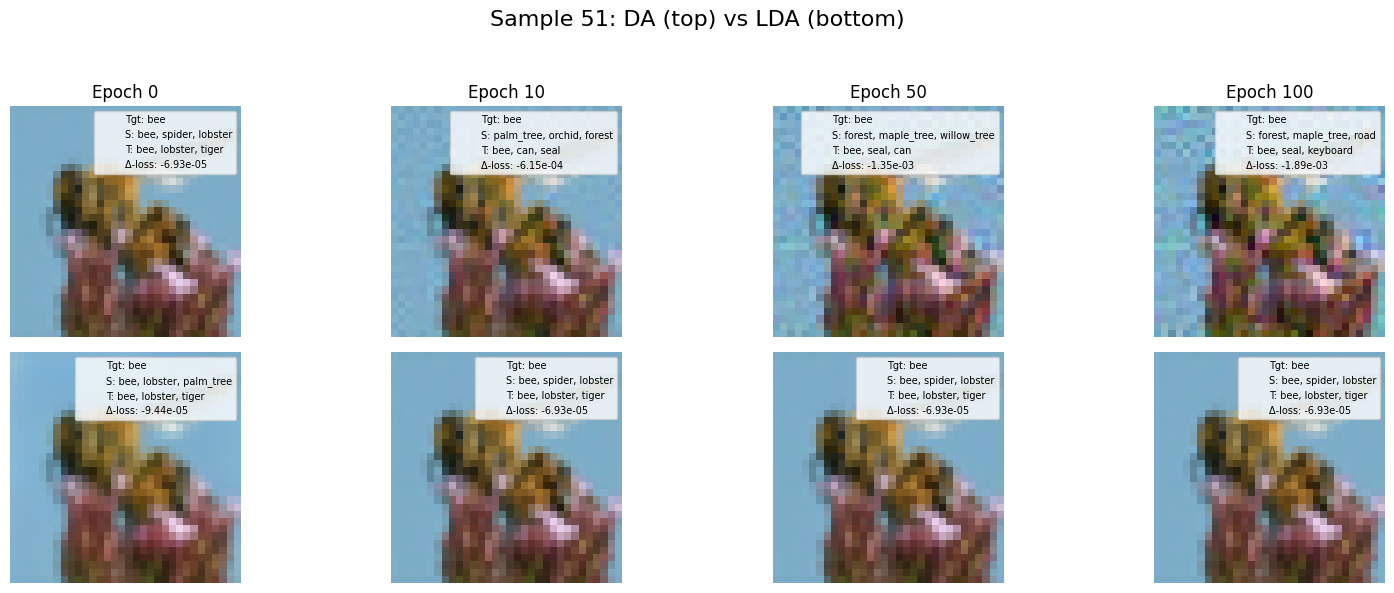

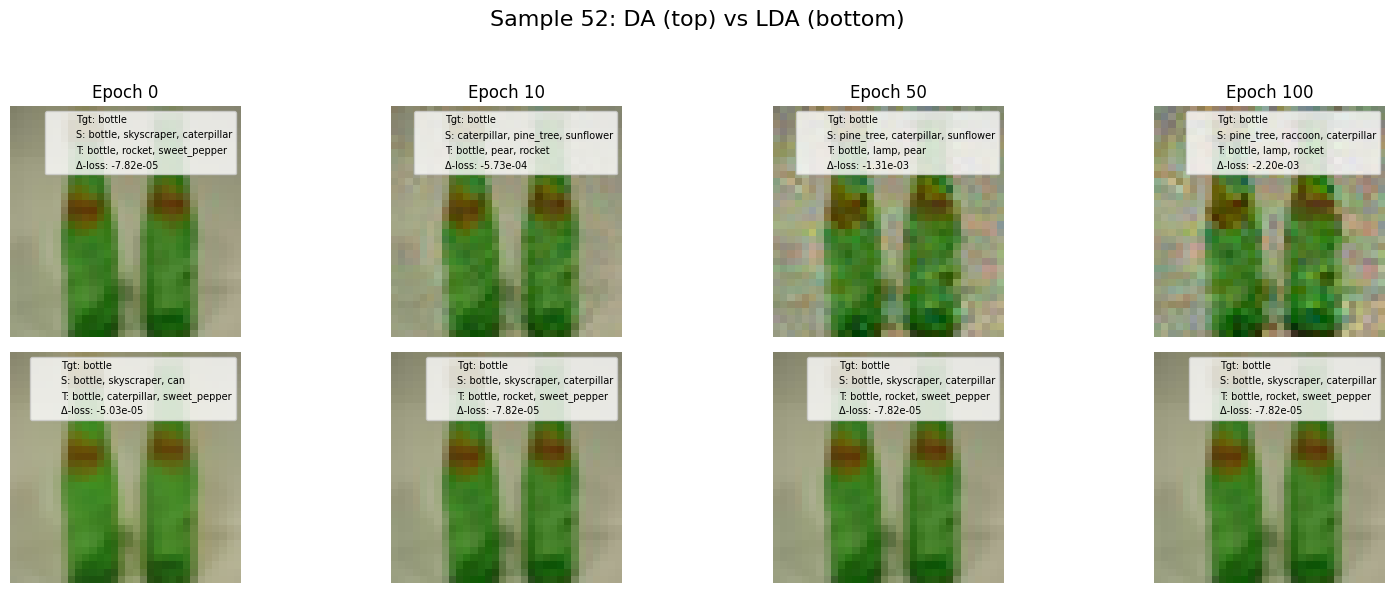

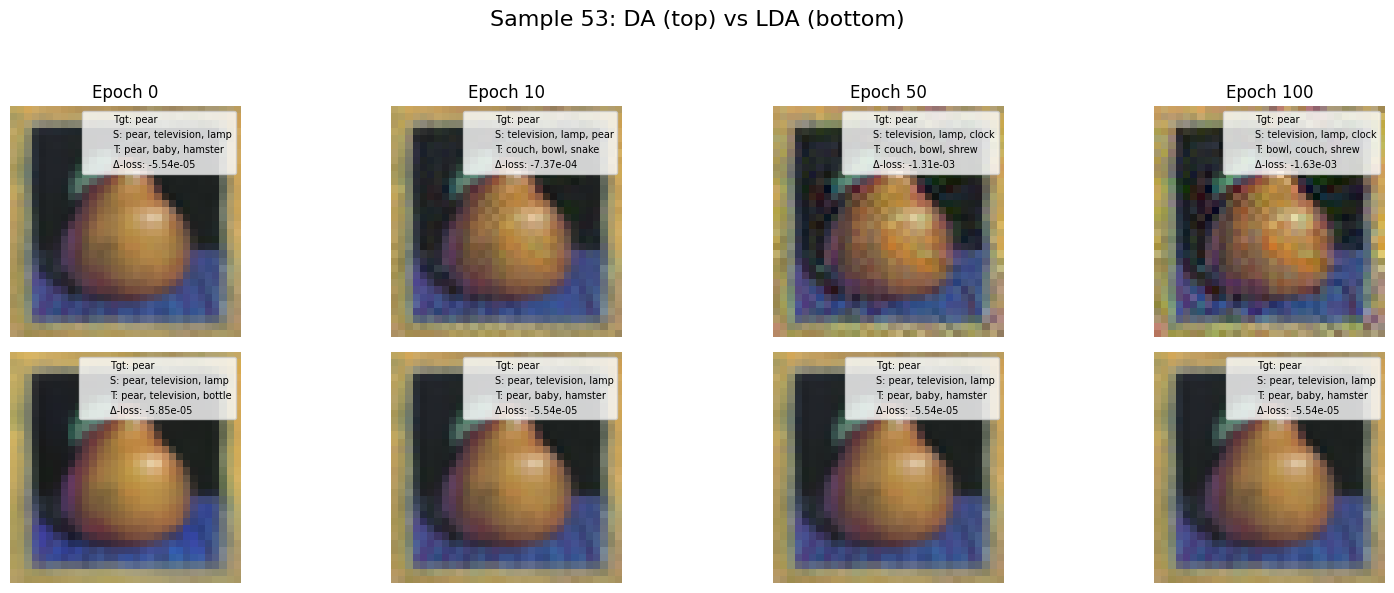

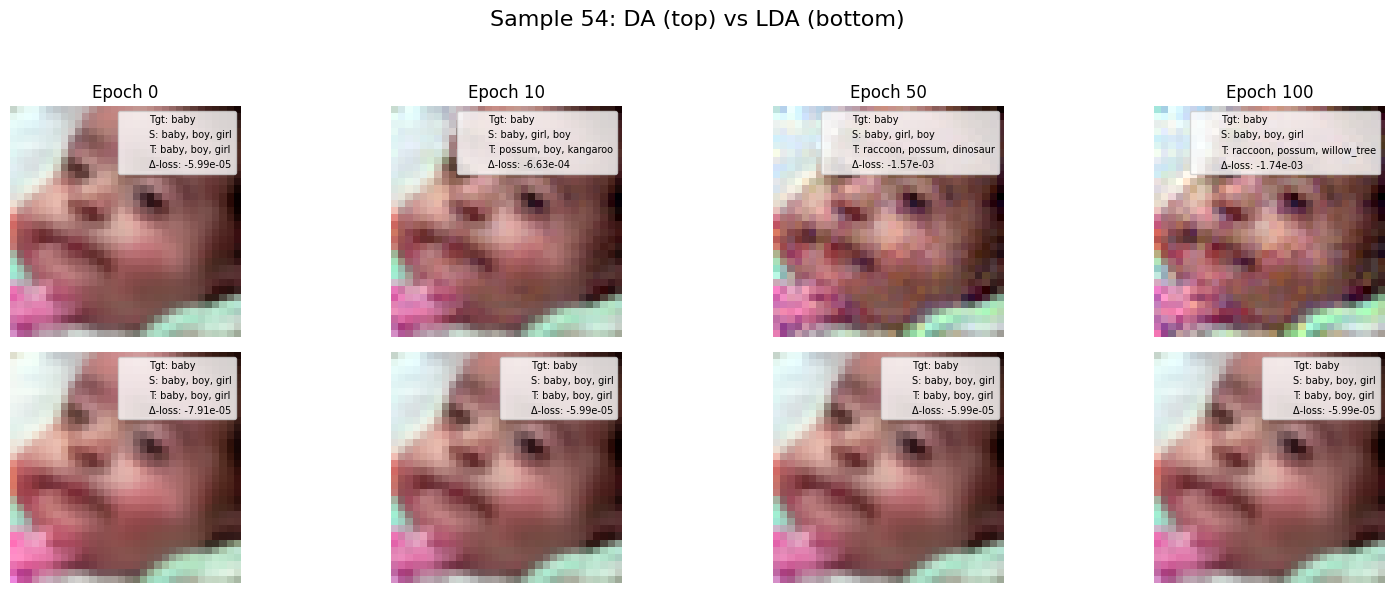

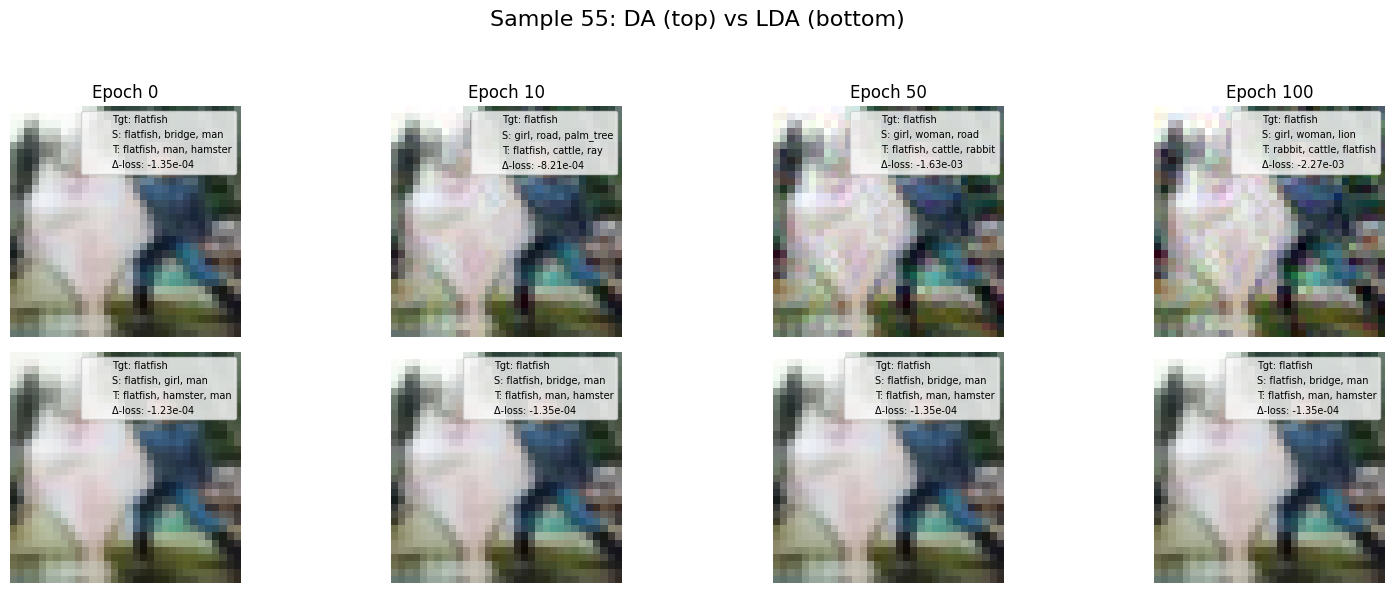

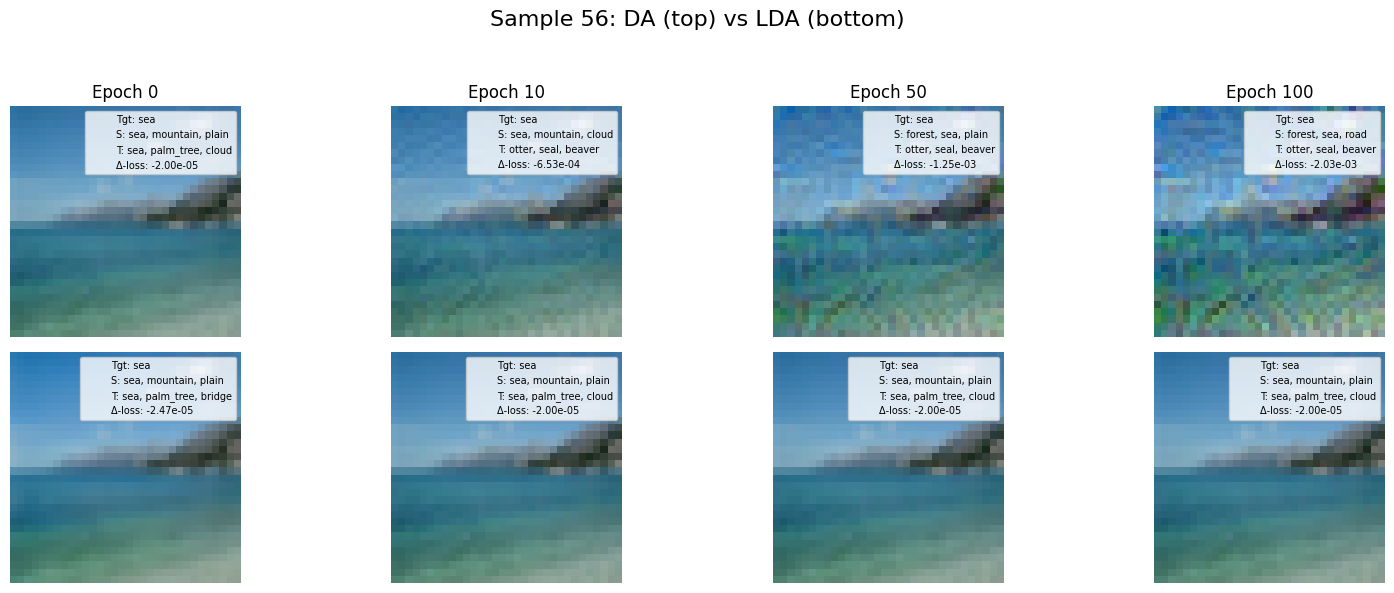

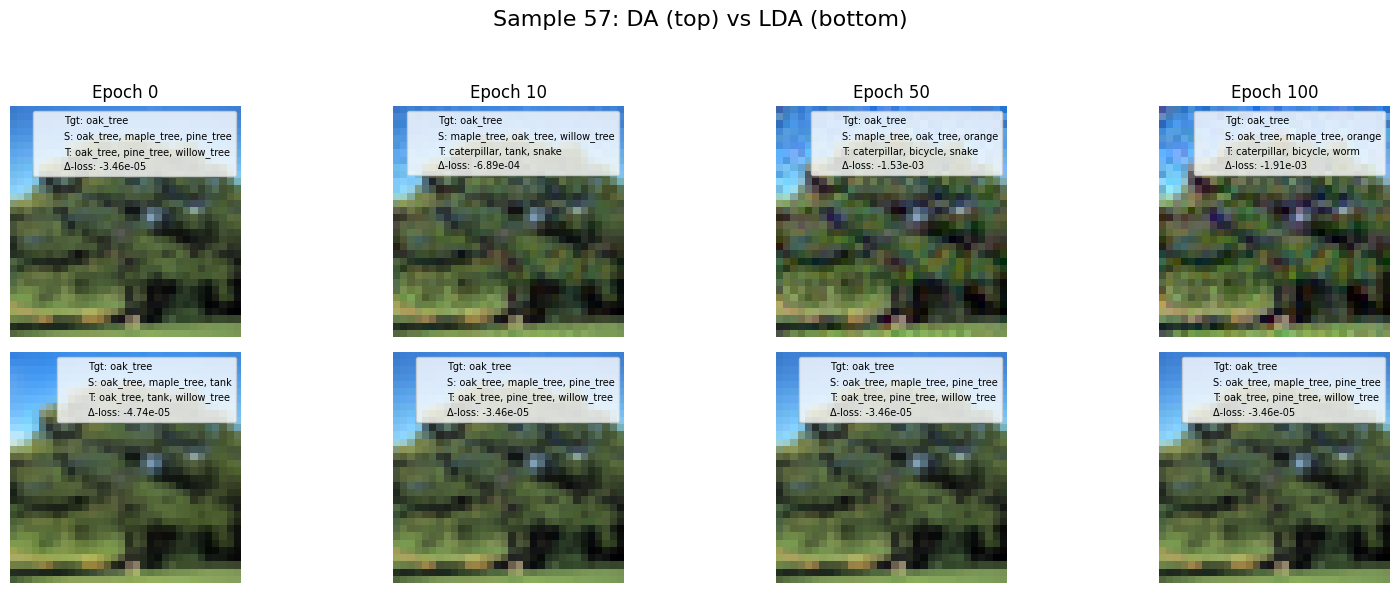

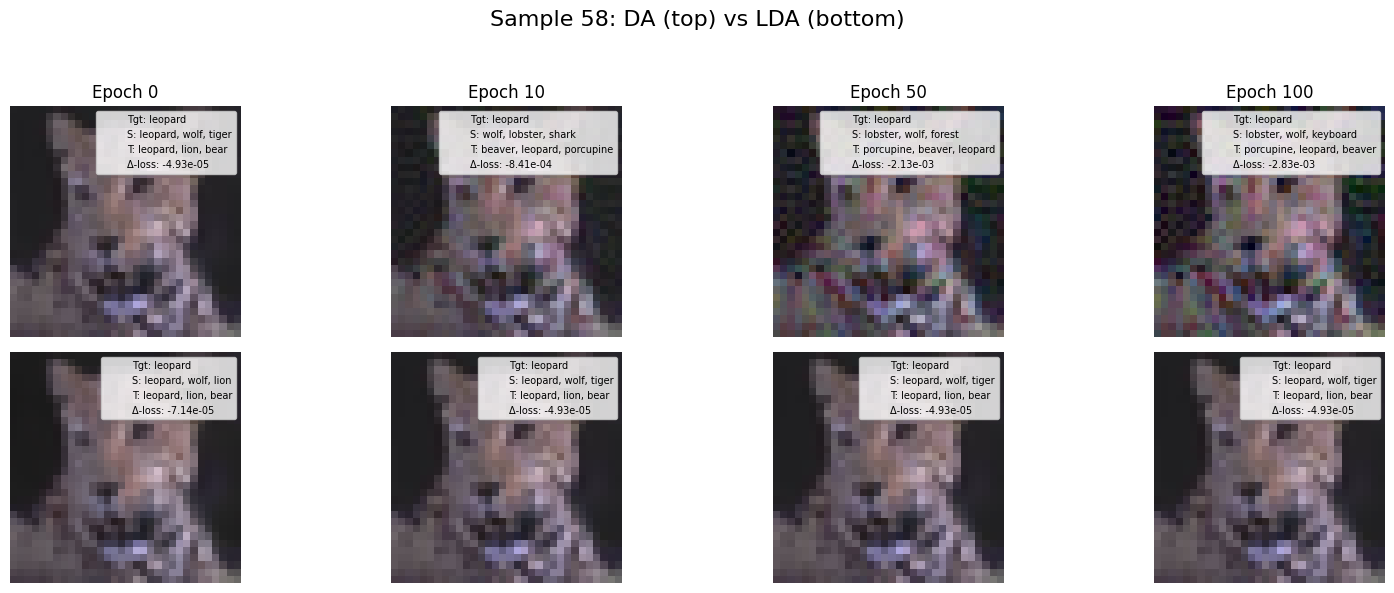

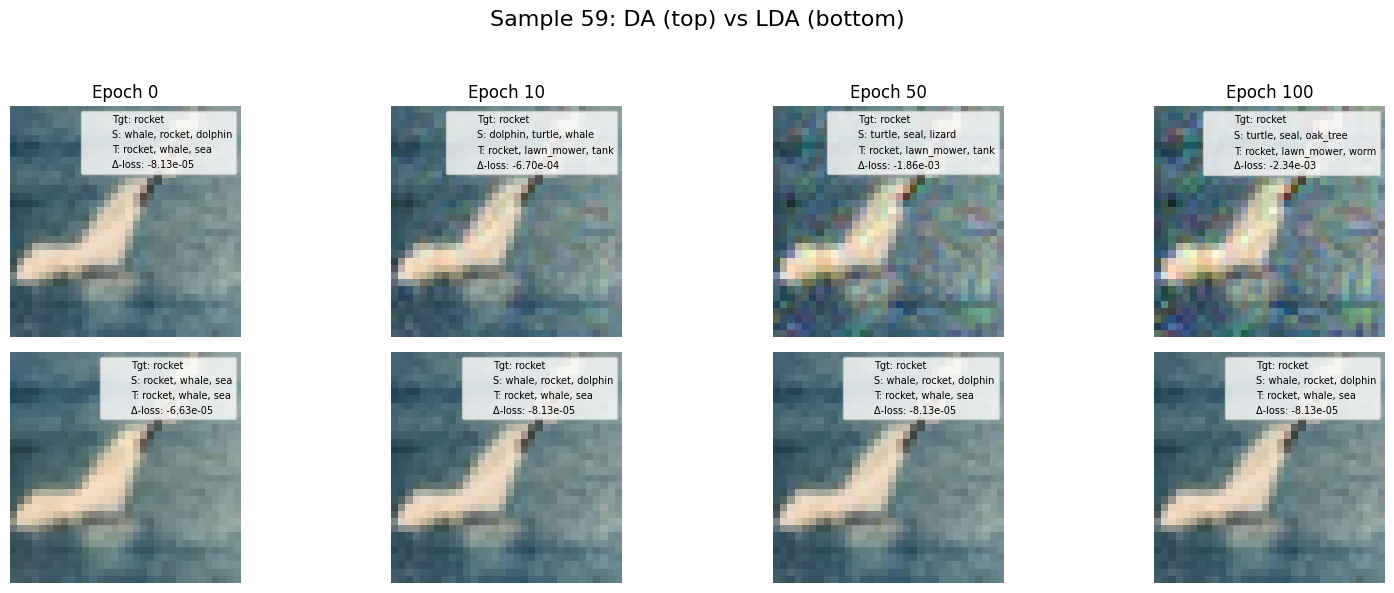

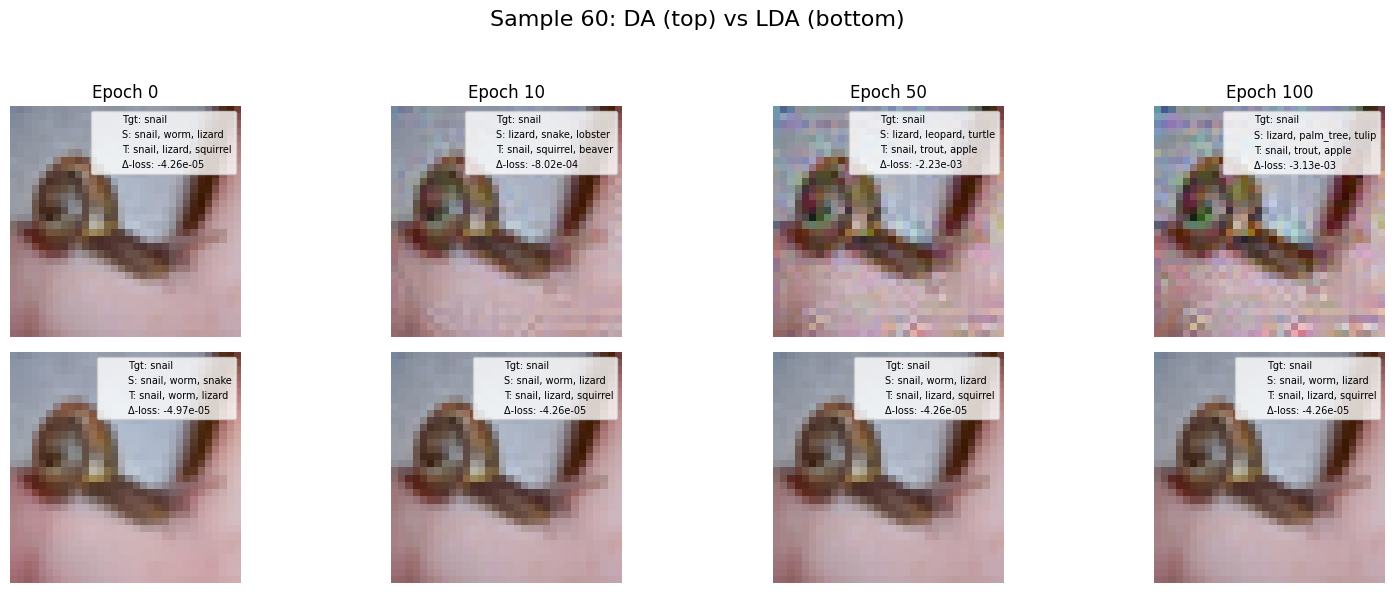

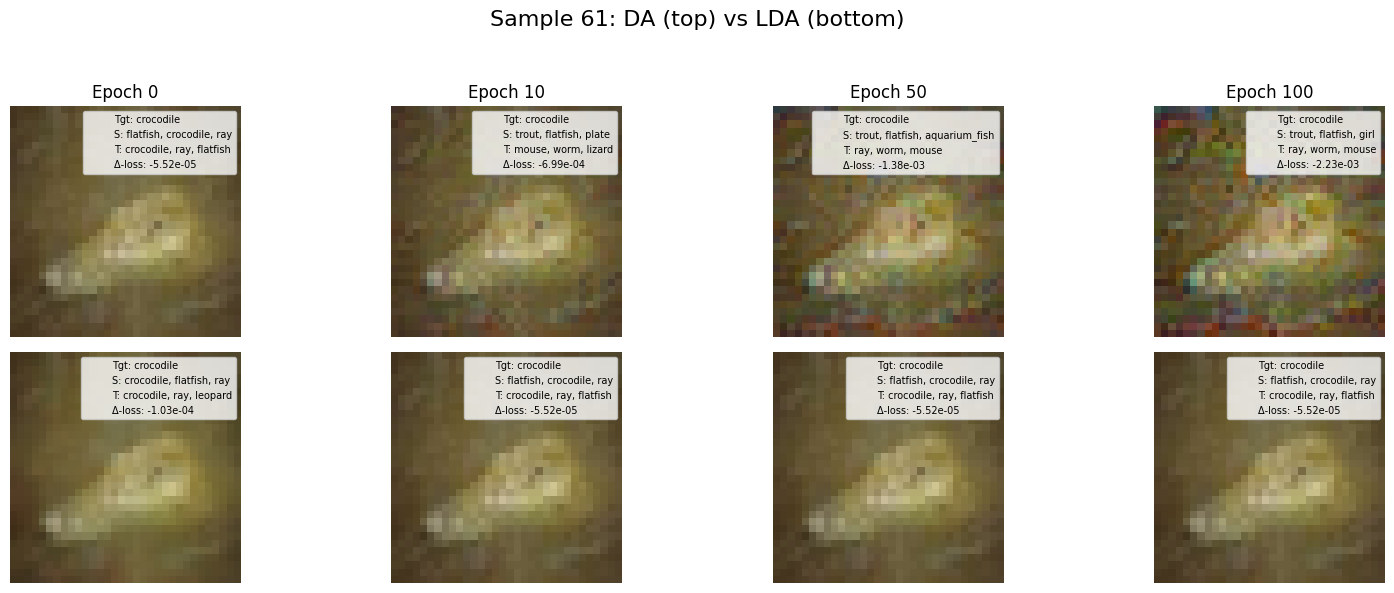

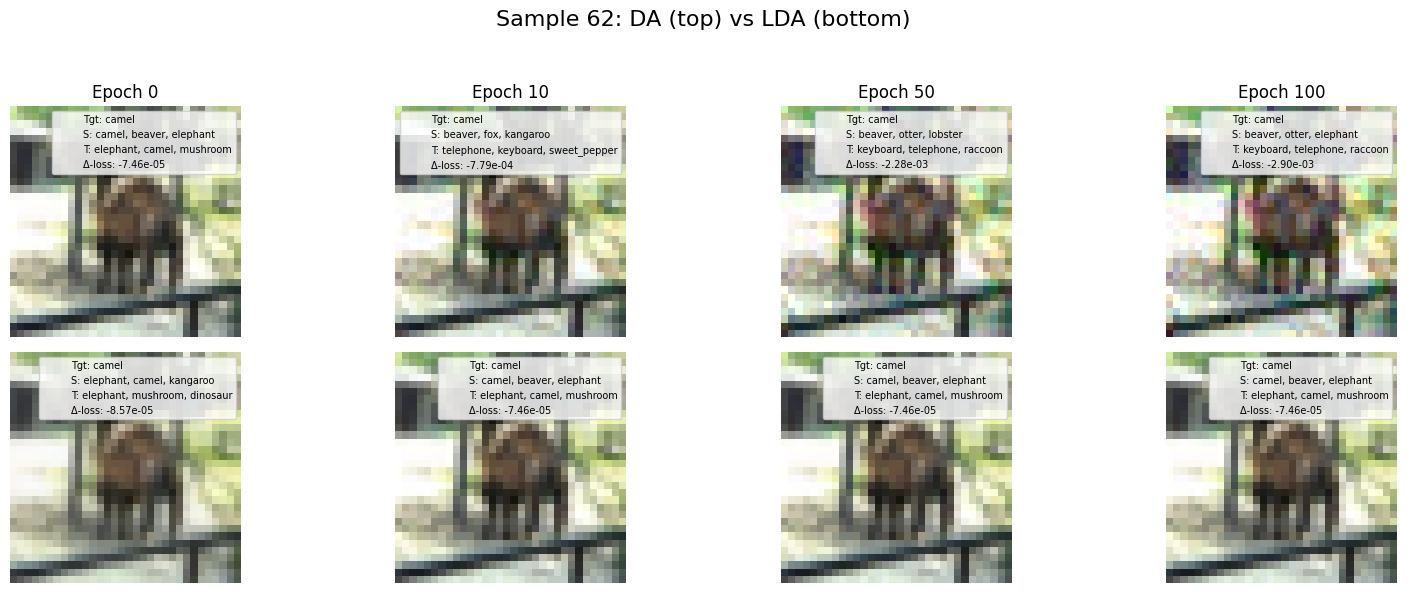

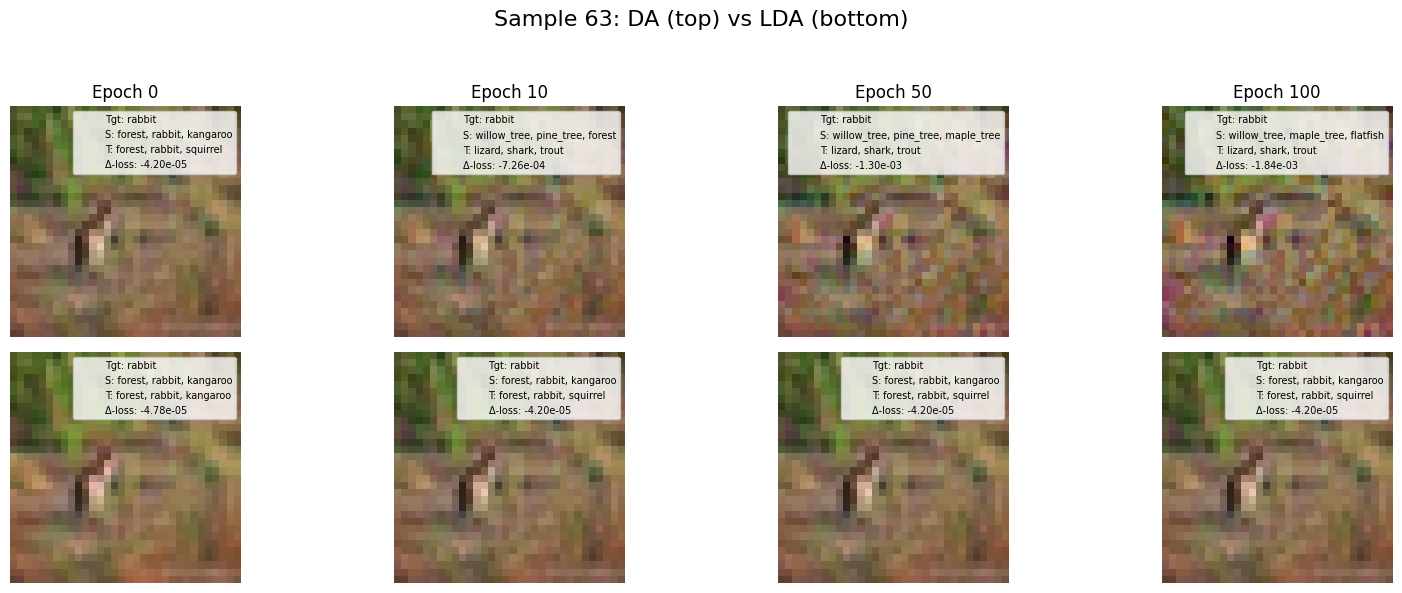

In [37]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from torchvision import datasets

# CIFAR-100 class index → label
id2label = datasets.CIFAR100(root=get_data_folder(), train=False, download=True).classes

# — USER CONFIG —
steps = [0, 10, 50, 100]
funcs = [("DA", DA), ("LDA", LDA)]
# — end config —

for before, target in val_loader:
    before = before.cuda()
    target = target.cpu()
    batch_size = before.size(0)

    # 1) generate & collect images, logits, losses for both DA & LDA
    all_imgs, all_s_logits, all_t_logits, all_losses = [], [], [], []
    for name, func in funcs:
        imgs = [func(before, distiller.module, s) for s in steps]
        # logits
        s_logits = [distiller.module.student(img)[0].cpu() for img in imgs]
        t_logits = [distiller.module.teacher(img)[0].cpu() for img in imgs]
        # losses
        losses = []
        for sl, tl in zip(s_logits, t_logits):
            ns = F.normalize(sl, p=1, dim=1)
            nt = F.normalize(tl, p=1, dim=1)
            losses.append((-1.0 * F.mse_loss(ns, nt, reduction='none').mean(dim=1)))
        # denorm & clamp
        imgs = [distiller.module.denormalize(img).clamp_(0,1).cpu() for img in imgs]

        all_imgs.append(imgs)
        all_s_logits.append(s_logits)
        all_t_logits.append(t_logits)
        all_losses.append(losses)

    # 2) for each sample in the batch, plot one 2×4 figure
    for i in range(batch_size):
        fig, axes = plt.subplots(2, len(steps), figsize=(4 * len(steps), 3 * 2))
        fig.suptitle(f"Sample {i}: DA (top) vs LDA (bottom)", fontsize=16)

        # column titles
        for j, s in enumerate(steps):
            axes[0, j].set_title(f"Epoch {s}")

        # draw each cell
        for row in [0, 1]:
            name = funcs[row][0]
            for col in range(len(steps)):
                ax = axes[row, col]
                img = all_imgs[row][col][i].permute(1,2,0).numpy()
                ax.imshow(img)
                ax.axis('off')

                # build legend
                sl = all_s_logits[row][col][i]
                tl = all_t_logits[row][col][i]
                top_s = [id2label[c] for c in torch.topk(sl, 3).indices.tolist()]
                top_t = [id2label[c] for c in torch.topk(tl, 3).indices.tolist()]
                tgt = id2label[target[i].item()]
                loss_val = all_losses[row][col][i].item()
                ann = [
                    Patch(color='none', label=f"Tgt: {tgt}"),
                    Patch(color='none', label=f"S: {', '.join(top_s)}"),
                    Patch(color='none', label=f"T: {', '.join(top_t)}"),
                    Patch(color='none', label=f"Δ-loss: {loss_val:.2e}")
                ]
                ax.legend(handles=ann, loc='upper right', fontsize=7)

        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.show()

    break  # remove if you want more batches
